In [36]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import itertools

from collections import defaultdict
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.special import softmax, expit
from scipy.stats import pearsonr
from math import ceil

import utils

In [37]:
def cf_values(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    tp = cf[1][1]
    fp = cf[0][1]
    fn = cf[1][0]
    tn = cf[0][0]
    return tp, fp, fn, tn

def precision(tp, fp, fn, tn): return tp / (tp + fp)
def recall(tp, fp, fn, tn): return tp / (tp + fn)
def specificity(tp, fp, fn, tn): return tn / (fp + tn)
def falarm(tp, fp, fn, tn): return fp / (tn + fp)
#def accuracy(tp, fp, fn, tn): return (tp + tn) / (tp + fp + fn + tn)
#def f1(tp, fp, fn, tn): return 2*tp / (2*tp + fn + tn)
#def mcc(tp, fp, fn, tn): return (tp*tn - fp*fn) / np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))

#def precision_score(y_true, y_pred): return precision(*cf_values(y_true, y_pred))
#def recall_score(y_true, y_pred): return recall(*cf_values(y_true, y_pred))
def specificity_score(y_true, y_pred): return specificity(*cf_values(y_true, y_pred))
#def falarm_score(y_true, y_pred): return falarm(*cf_values(y_true, y_pred))

metrics = {
    'precision': precision_score,
    'recall': recall_score,
    'specificity': specificity_score,
    #'falarm': falarm_score,
    'accuracy': accuracy_score,
    'f1': f1_score,
    'mcc': matthews_corrcoef
}


### Grid Search Results

In [3]:
GRID_SEARCH_DIRECTORIES_0 = [
    r'../results/classification/grid_search_1',
    r'../results/classification/grid_search_2',
    r'../results/classification/grid_search_3'
]

GRID_SEARCH_DIRECTORIES_1 = [
    r'../results/classification/grid_search_11',
    r'../results/classification/grid_search_12',
    r'../results/classification/grid_search_13'
]

GRID_SEARCH_DIRECTORIES_2 = [
    r'../results/classification/grid_search_21',
    r'../results/classification/grid_search_22',
    r'../results/classification/grid_search_23'
]

GRID_SEARCH_DIRECTORIES = GRID_SEARCH_DIRECTORIES_2

In [4]:
with open('{}/{}/hyperpar.json'.format(GRID_SEARCH_DIRECTORIES[0], '0')) as f:
    hyperpars = json.load(f)

training_data = hyperpars['train_dataset']
print('Dataset: {}'.format(training_data['name']))
print('Full dataset size: {}'.format(training_data['size']))
print('Subsample of size: {}'.format(training_data['subsample']))
print('Number of epochs: {}'.format(hyperpars['n_epochs']))

# Manual computation of batches
print('Train batches: {}'.format(
    ceil(training_data['subsample'] / 32) * hyperpars['n_epochs']
))

#print('Train batches: {}'.format(min(hyperpars['n_epochs'] * ceil((int(training_data['subsample']) / 32)), hyperpars['train_batches'])))

Dataset: ../datasets/new/classificator/germline_v/train_only_v/train_only_v.csv
Full dataset size: 1432650
Subsample of size: 71632
Number of epochs: 3
Train batches: 6717


In [5]:
with open('{}/{}/hyperpar_val_results.json'.format(GRID_SEARCH_DIRECTORIES[0], '0')) as f:
    hyperpars = json.load(f)

print('Dataset: {}'.format(hyperpars['name']))
print('Full dataset size: {}'.format(hyperpars['size']))
print('Subsample of size: {}'.format(hyperpars['subsample']))

Dataset: ../datasets/new/classificator/germline_v/val_only_v/val_only_v.csv
Full dataset size: 542466
Subsample of size: 81369


In [6]:
gs_results = defaultdict(dict)

for d in os.listdir(GRID_SEARCH_DIRECTORIES[0]):
    with open('{}/{}/hyperpar.json'.format(GRID_SEARCH_DIRECTORIES[0], d)) as f:
        hyperpars = json.load(f)
    
    gs_results[d]['number_of_layer'] = hyperpars['model']['number_of_layers']
    gs_results[d]['layer_size'] = hyperpars['model']['layer_size']
    gs_results[d]['lr'] = hyperpars['optimizer']['lr']
    gs_results[d]['weight_decay'] = hyperpars['optimizer']['weight_decay']

    #print(hyperpars)

    if 'lr_sched' not in hyperpars:
        gs_results[d]['lr_sched'] = 'None'
        gs_results[d]['start_factor'] = 'None'
        gs_results[d]['end_factor'] = 'None'
        gs_results[d]['total_iters'] = 'None'
    else:
        gs_results[d]['lr_sched'] = hyperpars['lr_sched']['name']
        gs_results[d]['start_factor'] = hyperpars['lr_sched']['start_factor']
        gs_results[d]['end_factor'] = hyperpars['lr_sched']['end_factor']
        gs_results[d]['total_iters'] = hyperpars['lr_sched']['total_iters']

    if 'beta1' in hyperpars['optimizer']:
        gs_results[d]['beta1'] = hyperpars['optimizer']['beta1']
        gs_results[d]['beta2'] = hyperpars['optimizer']['beta2']

In [7]:
for d1 in GRID_SEARCH_DIRECTORIES:
    for d2 in os.listdir(d1):
        df = pd.read_csv('{}/{}/val_results_classification.csv'.format(d1, d2), index_col=0)

        # Manually correct a bug. More sequences were tested
        #df = df.sample(27123, random_state=42)
        
        gs_results[d2]['acc_{}'.format(d1.split('_')[-1])] = accuracy_score(df['label'], df['prediction'])
        gs_results[d2]['f1_{}'.format(d1.split('_')[-1])] = f1_score(df['label'], df['prediction'])
        gs_results[d2]['mcc_{}'.format(d1.split('_')[-1])] = matthews_corrcoef(df['label'], df['prediction'])

In [8]:
dict_results = defaultdict(list)

for _, item in gs_results.items():
    for key, value in item.items():
        dict_results[key].append(value)

df_results = pd.DataFrame(dict_results)

acc_columns = sorted([c for c in df_results.columns if 'acc' in c])
f1_columns = sorted([c for c in df_results.columns if 'f1' in c])
mcc_columns = sorted([c for c in df_results.columns if 'mcc' in c])
other_columns = sorted(list(set(df_results.columns).difference(set(acc_columns + f1_columns + mcc_columns))))

df_results = df_results[other_columns + acc_columns + f1_columns + mcc_columns]

In [9]:
df_results = pd.merge(
    df_results,
    df_results[acc_columns].mean(axis=1).to_frame().rename({0: 'acc_mean'}, axis=1),
    left_index=True,
    right_index=True
)

df_results = pd.merge(
    df_results,
    df_results[acc_columns].std(axis=1).to_frame().rename({0: 'acc_std'}, axis=1),
    left_index=True,
    right_index=True
)

In [10]:
df_results = pd.merge(
    df_results,
    df_results[f1_columns].mean(axis=1).to_frame().rename({0: 'f1_mean'}, axis=1),
    left_index=True,
    right_index=True
)

df_results = pd.merge(
    df_results,
    df_results[f1_columns].std(axis=1).to_frame().rename({0: 'f1_std'}, axis=1),
    left_index=True,
    right_index=True
)

In [11]:
df_results = pd.merge(
    df_results,
    df_results[mcc_columns].mean(axis=1).to_frame().rename({0: 'mcc_mean'}, axis=1),
    left_index=True,
    right_index=True
)

df_results = pd.merge(
    df_results,
    df_results[mcc_columns].std(axis=1).to_frame().rename({0: 'mcc_std'}, axis=1),
    left_index=True,
    right_index=True
)

In [12]:
WHICH = 'acc'
df_results[other_columns + 
           ['{}_mean'.format(WHICH), '{}_std'.format(WHICH)]].sort_values(by='{}_mean'.format(WHICH), 
                                                                          ascending=False).head(5)

,beta1,beta2,end_factor,layer_size,lr,lr_sched,number_of_layer,start_factor,total_iters,weight_decay,acc_mean,acc_std
2,0.9,0.999,None,2048,0.0001,None,3,None,None,0.00010,0.999861,0.000089
3,0.9,0.999,None,1024,0.0001,None,5,None,None,0.00010,0.999844,0.000082
1,0.9,0.999,None,1024,0.0001,None,3,None,None,0.00001,0.999836,0.000007
22,0.9,0.999,None,2048,0.0001,None,5,None,None,0.00010,0.999820,0.000040
15,0.9,0.999,None,1024,0.0001,None,3,None,None,0.00100,0.999795,0.000007


In [13]:
WHICH = 'mcc'
df_results[other_columns + 
           ['{}_mean'.format(WHICH), '{}_std'.format(WHICH)]].sort_values(by='{}_mean'.format(WHICH), 
                                                                          ascending=False).head(5)

,beta1,beta2,end_factor,layer_size,lr,lr_sched,number_of_layer,start_factor,total_iters,weight_decay,mcc_mean,mcc_std
2,0.9,0.999,None,2048,0.0001,None,3,None,None,0.00010,0.999721,0.000178
3,0.9,0.999,None,1024,0.0001,None,5,None,None,0.00010,0.999689,0.000164
1,0.9,0.999,None,1024,0.0001,None,3,None,None,0.00001,0.999672,0.000014
22,0.9,0.999,None,2048,0.0001,None,5,None,None,0.00010,0.999640,0.000079
13,0.9,0.999,None,1024,0.0001,None,3,None,None,0.00010,0.999590,0.000038


In [13]:
WHICH = 'f1'
df_results[other_columns + 
           ['{}_mean'.format(WHICH), '{}_std'.format(WHICH)]].sort_values(by='{}_mean'.format(WHICH), 
                                                                          ascending=False).head(5)

,end_factor,layer_size,lr,lr_sched,number_of_layer,start_factor,total_iters,weight_decay,f1_mean,f1_std
21,None,2048,0.0001,None,5,None,None,0.00100,0.909543,0.001075
7,None,2048,0.0010,None,3,None,None,0.00010,0.908564,0.001891
4,None,1024,0.0001,None,3,None,None,0.00010,0.897694,0.020323
5,None,1024,0.0001,None,3,None,None,0.00001,0.895996,0.014517
2,None,1024,0.0010,None,3,None,None,0.00001,0.892886,0.018084


### Second Grid Search

In [2]:
GRID_SEARCH_DIRECTORIES = [
    r'../results/classification/grid_search_4',
    r'../results/classification/grid_search_5',
    r'../results/classification/grid_search_6'
]

#GRID_SEARCH_DIRECTORIES = [
#    r'../results/classification/grid_search_14',
#    r'../results/classification/grid_search_15',
#    r'../results/classification/grid_search_16'
#]

In [3]:
with open('{}/{}/hyperpar.json'.format(GRID_SEARCH_DIRECTORIES[0], '0')) as f:
    hyperpars = json.load(f)

training_data = hyperpars['train_dataset']
print('Dataset: {}'.format(training_data['name']))
print('Full dataset size: {}'.format(training_data['size']))
print('Subsample of size: {}'.format(training_data['subsample']))
#print('Number of epochs: {}'.format(hyperpars['n_epochs']))

# Manual computation of batches
print('Train batches: {}'.format(hyperpars['train_batches']))

Dataset: ../datasets/new/classificator/germline_all/train/train.csv
Full dataset size: 1432650
Subsample of size: None
Train batches: 10000


In [4]:
with open('{}/{}/hyperpar_val_results.json'.format(GRID_SEARCH_DIRECTORIES[0], '0')) as f:
    hyperpars = json.load(f)

print('Dataset: {}'.format(hyperpars['name']))
print('Full dataset size: {}'.format(hyperpars['size']))
print('Subsample of size: {}'.format(hyperpars['subsample']))

Dataset: ../datasets/new/classificator/germline_all/val/val.csv
Full dataset size: 542466
Subsample of size: 81369


In [5]:
gs_results = defaultdict(dict)

for d in os.listdir(GRID_SEARCH_DIRECTORIES[0]):
    with open('{}/{}/hyperpar.json'.format(GRID_SEARCH_DIRECTORIES[0], d)) as f:
        hyperpars = json.load(f)
    
    gs_results[d]['number_of_layer'] = hyperpars['model']['number_of_layers']
    gs_results[d]['layer_size'] = hyperpars['model']['layer_size']
    gs_results[d]['lr'] = hyperpars['optimizer']['lr']
    gs_results[d]['weight_decay'] = hyperpars['optimizer']['weight_decay']

    #print(hyperpars)

    if 'lr_sched' not in hyperpars:
        gs_results[d]['lr_sched'] = 'None'
        gs_results[d]['start_factor'] = 'None'
        gs_results[d]['end_factor'] = 'None'
        gs_results[d]['total_iters'] = 'None'
    else:
        gs_results[d]['lr_sched'] = hyperpars['lr_sched']['name']
        gs_results[d]['start_factor'] = hyperpars['lr_sched']['start_factor']
        gs_results[d]['end_factor'] = hyperpars['lr_sched']['end_factor']
        gs_results[d]['total_iters'] = hyperpars['lr_sched']['total_iters']

    if 'beta1' in hyperpars['optimizer']:
        gs_results[d]['beta1'] = hyperpars['optimizer']['beta1']
        gs_results[d]['beta2'] = hyperpars['optimizer']['beta2']

In [6]:
for d1 in GRID_SEARCH_DIRECTORIES:
    for d2 in os.listdir(d1):
        df = pd.read_csv('{}/{}/val_results_classification.csv'.format(d1, d2), index_col=0)
        gs_results[d2]['acc_{}'.format(d1.split('_')[-1])] = accuracy_score(df['label'], df['prediction'])
        gs_results[d2]['f1_{}'.format(d1.split('_')[-1])] = f1_score(df['label'], df['prediction'])
        gs_results[d2]['mcc_{}'.format(d1.split('_')[-1])] = matthews_corrcoef(df['label'], df['prediction'])

In [7]:
dict_results = defaultdict(list)

for _, item in gs_results.items():
    for key, value in item.items():
        dict_results[key].append(value)

df_results = pd.DataFrame(dict_results)

acc_columns = sorted([c for c in df_results.columns if 'acc' in c])
f1_columns = sorted([c for c in df_results.columns if 'f1' in c])
mcc_columns = sorted([c for c in df_results.columns if 'mcc' in c])
other_columns = sorted(list(set(df_results.columns).difference(set(acc_columns + f1_columns + mcc_columns))))

df_results = df_results[other_columns + acc_columns + f1_columns + mcc_columns]

In [8]:
df_results = pd.merge(
    df_results,
    df_results[acc_columns].mean(axis=1).to_frame().rename({0: 'acc_mean'}, axis=1),
    left_index=True,
    right_index=True
)

df_results = pd.merge(
    df_results,
    df_results[acc_columns].std(axis=1).to_frame().rename({0: 'acc_std'}, axis=1),
    left_index=True,
    right_index=True
)

In [9]:
df_results = pd.merge(
    df_results,
    df_results[f1_columns].mean(axis=1).to_frame().rename({0: 'f1_mean'}, axis=1),
    left_index=True,
    right_index=True
)

df_results = pd.merge(
    df_results,
    df_results[f1_columns].std(axis=1).to_frame().rename({0: 'f1_std'}, axis=1),
    left_index=True,
    right_index=True
)

In [10]:
df_results = pd.merge(
    df_results,
    df_results[mcc_columns].mean(axis=1).to_frame().rename({0: 'mcc_mean'}, axis=1),
    left_index=True,
    right_index=True
)

df_results = pd.merge(
    df_results,
    df_results[mcc_columns].std(axis=1).to_frame().rename({0: 'mcc_std'}, axis=1),
    left_index=True,
    right_index=True
)

In [11]:
WHICH = 'acc'
df_results[other_columns + 
           ['{}_mean'.format(WHICH), '{}_std'.format(WHICH)]].sort_values(by='{}_mean'.format(WHICH), 
                                                                          ascending=False).head(5)

,beta1,beta2,end_factor,layer_size,lr,lr_sched,number_of_layer,start_factor,total_iters,weight_decay,acc_mean,acc_std
1,0.999,0.999,0.1,2048,0.0001,linear,5,1,1000,0.001,0.907012,0.001362
2,0.999,0.999,0.05,2048,0.0001,linear,5,1,1000,0.001,0.904288,0.003138
0,0.999,0.999,None,2048,0.0001,None,5,None,None,0.001,0.899859,0.010560
5,0.999,0.999,0.05,2048,0.0001,linear,5,1,2000,0.001,0.899462,0.002677
4,0.999,0.999,0.1,2048,0.0001,linear,5,1,2000,0.001,0.897774,0.004352


In [14]:
WHICH = 'mcc'
df_results[other_columns + 
           ['{}_mean'.format(WHICH), '{}_std'.format(WHICH)]].sort_values(by='{}_mean'.format(WHICH), 
                                                                          ascending=False).head(5)

,beta1,beta2,end_factor,layer_size,lr,lr_sched,number_of_layer,start_factor,total_iters,weight_decay,mcc_mean,mcc_std
1,0.999,0.999,0.1,2048,0.0001,linear,5,1,1000,0.001,0.814177,0.002696
2,0.999,0.999,0.05,2048,0.0001,linear,5,1,1000,0.001,0.808662,0.006215
0,0.999,0.999,None,2048,0.0001,None,5,None,None,0.001,0.801183,0.020590
5,0.999,0.999,0.05,2048,0.0001,linear,5,1,2000,0.001,0.799177,0.005089
4,0.999,0.999,0.1,2048,0.0001,linear,5,1,2000,0.001,0.797558,0.007448


In [15]:
WHICH = 'f1'
df_results[other_columns + 
           ['{}_mean'.format(WHICH), '{}_std'.format(WHICH)]].sort_values(by='{}_mean'.format(WHICH), 
                                                                          ascending=False).head(5)

,beta1,beta2,end_factor,layer_size,lr,lr_sched,number_of_layer,start_factor,total_iters,weight_decay,f1_mean,f1_std
1,0.999,0.999,0.1,2048,0.0001,linear,5,1,1000,0.001,0.907241,0.002320
2,0.999,0.999,0.05,2048,0.0001,linear,5,1,1000,0.001,0.903822,0.003594
5,0.999,0.999,0.05,2048,0.0001,linear,5,1,2000,0.001,0.898475,0.003424
0,0.999,0.999,None,2048,0.0001,None,5,None,None,0.001,0.896953,0.011680
4,0.999,0.999,0.1,2048,0.0001,linear,5,1,2000,0.001,0.894233,0.005816


### Third grid search

In [28]:
GRID_SEARCH_DIRECTORIES = [
    r'../results/classification/grid_search_7',
    r'../results/classification/grid_search_8',
    r'../results/classification/grid_search_9'
]

In [29]:
with open('{}/{}/hyperpar.json'.format(GRID_SEARCH_DIRECTORIES[0], '0')) as f:
    hyperpars = json.load(f)

training_data = hyperpars['train_dataset']
print('Dataset: {}'.format(training_data['name']))
print('Full dataset size: {}'.format(training_data['size']))
print('Subsample of size: {}'.format(training_data['subsample']))
#print('Number of epochs: {}'.format(hyperpars['n_epochs']))

# Manual computation of batches
print('Train batches: {}'.format(hyperpars['train_batches']))

Dataset: ../datasets/new/classificator/germline_all/train/train.csv
Full dataset size: 1432650
Subsample of size: None
Train batches: 10000


In [30]:
with open('{}/{}/hyperpar_val_results.json'.format(GRID_SEARCH_DIRECTORIES[0], '0')) as f:
    hyperpars = json.load(f)

print('Dataset: {}'.format(hyperpars['name']))
print('Full dataset size: {}'.format(hyperpars['size']))
print('Subsample of size: {}'.format(hyperpars['subsample']))

Dataset: ../datasets/new/classificator/germline_all/val/val.csv
Full dataset size: 542466
Subsample of size: 81369


In [31]:
gs_results = defaultdict(dict)

for d in os.listdir(GRID_SEARCH_DIRECTORIES[0]):
    with open('{}/{}/hyperpar.json'.format(GRID_SEARCH_DIRECTORIES[0], d)) as f:
        hyperpars = json.load(f)
    
    gs_results[d]['number_of_layer'] = hyperpars['model']['number_of_layers']
    gs_results[d]['layer_size'] = hyperpars['model']['layer_size']
    gs_results[d]['lr'] = hyperpars['optimizer']['lr']
    gs_results[d]['weight_decay'] = hyperpars['optimizer']['weight_decay']

    #print(hyperpars)

    if 'lr_sched' not in hyperpars:
        gs_results[d]['lr_sched'] = 'None'
        gs_results[d]['start_factor'] = 'None'
        gs_results[d]['end_factor'] = 'None'
        gs_results[d]['total_iters'] = 'None'
    else:
        gs_results[d]['lr_sched'] = hyperpars['lr_sched']['name']
        gs_results[d]['start_factor'] = hyperpars['lr_sched']['start_factor']
        gs_results[d]['end_factor'] = hyperpars['lr_sched']['end_factor']
        gs_results[d]['total_iters'] = hyperpars['lr_sched']['total_iters']

    if 'beta1' in hyperpars['optimizer']:
        gs_results[d]['beta1'] = hyperpars['optimizer']['beta1']
        gs_results[d]['beta2'] = hyperpars['optimizer']['beta2']

In [32]:
for d1 in GRID_SEARCH_DIRECTORIES:
    for d2 in os.listdir(d1):
        df = pd.read_csv('{}/{}/val_results_classification.csv'.format(d1, d2), index_col=0)
        gs_results[d2]['acc_{}'.format(d1.split('_')[-1])] = accuracy_score(df['label'], df['prediction'])
        gs_results[d2]['f1_{}'.format(d1.split('_')[-1])] = f1_score(df['label'], df['prediction'])
        gs_results[d2]['mcc_{}'.format(d1.split('_')[-1])] = matthews_corrcoef(df['label'], df['prediction'])

In [33]:
dict_results = defaultdict(list)

for _, item in gs_results.items():
    for key, value in item.items():
        dict_results[key].append(value)

df_results = pd.DataFrame(dict_results)

acc_columns = sorted([c for c in df_results.columns if 'acc' in c])
f1_columns = sorted([c for c in df_results.columns if 'f1' in c])
mcc_columns = sorted([c for c in df_results.columns if 'mcc' in c])
other_columns = sorted(list(set(df_results.columns).difference(set(acc_columns + f1_columns + mcc_columns))))

df_results = df_results[other_columns + acc_columns + f1_columns + mcc_columns]

In [34]:
df_results = pd.merge(
    df_results,
    df_results[acc_columns].mean(axis=1).to_frame().rename({0: 'acc_mean'}, axis=1),
    left_index=True,
    right_index=True
)

df_results = pd.merge(
    df_results,
    df_results[acc_columns].std(axis=1).to_frame().rename({0: 'acc_std'}, axis=1),
    left_index=True,
    right_index=True
)

In [35]:
df_results = pd.merge(
    df_results,
    df_results[f1_columns].mean(axis=1).to_frame().rename({0: 'f1_mean'}, axis=1),
    left_index=True,
    right_index=True
)

df_results = pd.merge(
    df_results,
    df_results[f1_columns].std(axis=1).to_frame().rename({0: 'f1_std'}, axis=1),
    left_index=True,
    right_index=True
)

In [36]:
df_results = pd.merge(
    df_results,
    df_results[mcc_columns].mean(axis=1).to_frame().rename({0: 'mcc_mean'}, axis=1),
    left_index=True,
    right_index=True
)

df_results = pd.merge(
    df_results,
    df_results[mcc_columns].std(axis=1).to_frame().rename({0: 'mcc_std'}, axis=1),
    left_index=True,
    right_index=True
)

In [37]:
WHICH = 'acc'
df_results[other_columns + 
           ['{}_mean'.format(WHICH), '{}_std'.format(WHICH)]].sort_values(by='{}_mean'.format(WHICH), 
                                                                          ascending=False).head(5)

,beta1,beta2,end_factor,layer_size,lr,lr_sched,number_of_layer,start_factor,total_iters,weight_decay,acc_mean,acc_std
6,0.95,0.960,0.1,2048,0.0001,linear,5,1,1000,0.001,0.911826,0.002494
11,0.85,0.940,0.1,2048,0.0001,linear,5,1,1000,0.001,0.910404,0.002467
1,0.90,0.980,0.1,2048,0.0001,linear,5,1,1000,0.001,0.909454,0.003087
15,0.80,0.940,0.1,2048,0.0001,linear,5,1,1000,0.001,0.908171,0.002609
8,0.85,0.999,0.1,2048,0.0001,linear,5,1,1000,0.001,0.907741,0.006741


In [38]:
WHICH = 'mcc'
df_results[other_columns + 
           ['{}_mean'.format(WHICH), '{}_std'.format(WHICH)]].sort_values(by='{}_mean'.format(WHICH), 
                                                                          ascending=False).head(5)

,beta1,beta2,end_factor,layer_size,lr,lr_sched,number_of_layer,start_factor,total_iters,weight_decay,mcc_mean,mcc_std
6,0.95,0.960,0.1,2048,0.0001,linear,5,1,1000,0.001,0.824406,0.004475
11,0.85,0.940,0.1,2048,0.0001,linear,5,1,1000,0.001,0.821078,0.004694
1,0.90,0.980,0.1,2048,0.0001,linear,5,1,1000,0.001,0.819419,0.005535
15,0.80,0.940,0.1,2048,0.0001,linear,5,1,1000,0.001,0.818542,0.004561
8,0.85,0.999,0.1,2048,0.0001,linear,5,1,1000,0.001,0.816503,0.012370


In [39]:
WHICH = 'f1'
df_results[other_columns + 
           ['{}_mean'.format(WHICH), '{}_std'.format(WHICH)]].sort_values(by='{}_mean'.format(WHICH), 
                                                                          ascending=False).head(5)

,beta1,beta2,end_factor,layer_size,lr,lr_sched,number_of_layer,start_factor,total_iters,weight_decay,f1_mean,f1_std
6,0.95,0.96,0.1,2048,0.0001,linear,5,1,1000,0.001,0.912394,0.003458
15,0.80,0.94,0.1,2048,0.0001,linear,5,1,1000,0.001,0.911488,0.002053
11,0.85,0.94,0.1,2048,0.0001,linear,5,1,1000,0.001,0.909602,0.003376
1,0.90,0.98,0.1,2048,0.0001,linear,5,1,1000,0.001,0.908514,0.004684
5,0.95,0.98,0.1,2048,0.0001,linear,5,1,1000,0.001,0.906824,0.009311


### OLD -Final model 

In [26]:
DIRECTORIES = [
    r'../results/classification/final_train_1', 
    r'../results/classification/final_train_2',
    r'../results/classification/final_train_3' 
]

In [27]:
learning_curves_train = [pd.read_csv('{}/results_train.csv'.format(d), index_col=0) for d in DIRECTORIES]
learning_curves_eval = [pd.read_csv('{}/results_eval.csv'.format(d), index_col=0) for d in DIRECTORIES]

In [28]:
with open('{}/hyperpar.json'.format(DIRECTORIES[0])) as f:
    hyperpars = json.load(f)

print('Training dataset:    {}'.format(hyperpars['train_dataset']['name']))
print('Size of the dataset: {}'.format(hyperpars['train_dataset']['size']))
print('    Subsample:       {}'.format(hyperpars['train_dataset']['subsample']))
print('    Frac:            {}'.format(hyperpars['train_dataset']['frac']))
print()
print('Validation dataset:  {}'.format(hyperpars['val_dataset']['name']))
print('Size of the dataset: {}'.format(hyperpars['val_dataset']['size']))
print('    Subsample:       {}'.format(hyperpars['val_dataset']['subsample']))
print('    Frac:            {}'.format(hyperpars['val_dataset']['frac']))
print()
print('Model:               {}'.format(hyperpars['model']['name']))
print('    Checkpoint:      {}'.format(hyperpars['model']['checkpoint']))
print('    N. layers:       {}'.format(hyperpars['model']['number_of_layers']))
print('    Layer size:      {}'.format(hyperpars['model']['layer_size']))
print()
print('Optimizer            {}'.format(hyperpars['optimizer']['name']))
print('    Lr:              {}'.format(hyperpars['optimizer']['lr']))
print('    Weight decay:    {}'.format(hyperpars['optimizer']['weight_decay']))
print('    Beta1:           {}'.format(hyperpars['optimizer']['beta1']))
print('    Beta2:           {}'.format(hyperpars['optimizer']['beta2']))
print()
print('Scheduler            {}'.format(hyperpars['lr_sched']['name']))
print('    Start factor:    {}'.format(hyperpars['lr_sched']['start_factor']))
print('    End factor:      {}'.format(hyperpars['lr_sched']['end_factor']))
print('    Tot. iters:      {}'.format(hyperpars['lr_sched']['total_iters']))
print()
print('N. epochs            {}'.format(hyperpars['n_epochs']))
print('Train batches:       {}'.format(hyperpars['train_batches']))
print('Eval batches:        {}'.format(hyperpars['eval_batches']))
print('Evaluate every:      {}'.format(hyperpars['evaluate_every']))
print('Mean last:           {}'.format(hyperpars['mean_last']))
print()
print('Note! Batch size: 32')

Training dataset:    ../datasets/new/classificator/germline_all/train/train.csv
Size of the dataset: 1432650
    Subsample:       None
    Frac:            None

Validation dataset:  ../datasets/new/classificator/germline_all/val/val.csv
Size of the dataset: 542466
    Subsample:       None
    Frac:            None

Model:               average
    Checkpoint:      Exscientia/IgBert
    N. layers:       5
    Layer size:      2048

Optimizer            adam
    Lr:              0.0001
    Weight decay:    0.001
    Beta1:           0.95
    Beta2:           0.96

Scheduler            linear
    Start factor:    1
    End factor:      0.1
    Tot. iters:      1000

N. epochs            1
Train batches:       None
Eval batches:        30
Evaluate every:      100
Mean last:           20

Note! Batch size: 32


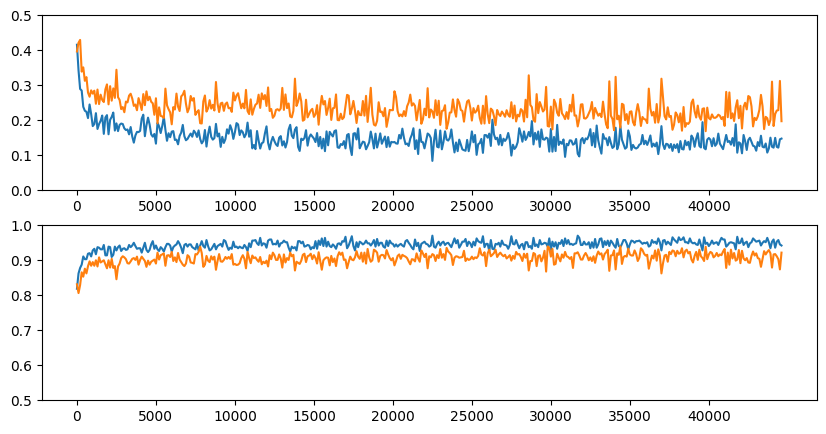

In [29]:
WHICH = 2

fig, axs = plt.subplots(2, 1)

axs[0].plot(learning_curves_train[WHICH]['loss_mean'])
axs[0].plot(learning_curves_eval[WHICH]['loss_mean'])

axs[0].set_ylim(0, 0.5)

axs[1].plot(learning_curves_train[WHICH]['accuracy_mean'])
axs[1].plot(learning_curves_eval[WHICH]['accuracy_mean'])

axs[1].set_ylim(0.5, 1)

x_ticks = [x for x in range(0, len(learning_curves_train[WHICH]['loss_mean']), 50)]
x_ticklabels = [x*int(hyperpars['evaluate_every']) for x in x_ticks]

axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(x_ticklabels)

axs[1].set_xticks(x_ticks)
axs[1].set_xticklabels(x_ticklabels)

fig.set_size_inches(10, 5)

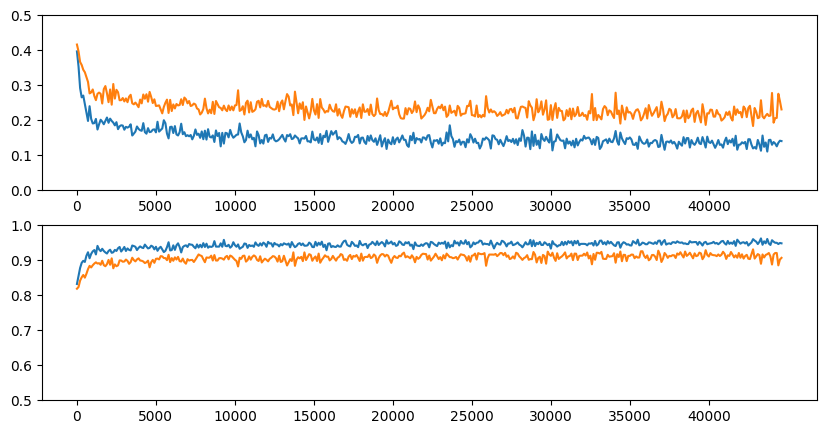

In [30]:
mean_tr_loss = np.mean([df['loss_mean'].to_numpy() for df in learning_curves_train], axis=0)
std_tr_loss = np.std([df['loss_mean'].to_numpy() for df in learning_curves_train], axis=0)

mean_tr_acc = np.mean([df['accuracy_mean'].to_numpy() for df in learning_curves_train], axis=0)
std_tr_acc = np.std([df['accuracy_mean'].to_numpy() for df in learning_curves_train], axis=0)

mean_vl_loss = np.mean([df['loss_mean'].to_numpy() for df in learning_curves_eval], axis=0)
std_vl_loss = np.std([df['loss_mean'].to_numpy() for df in learning_curves_eval], axis=0)

mean_vl_acc = np.mean([df['accuracy_mean'].to_numpy() for df in learning_curves_eval], axis=0)
std_vl_acc = np.std([df['accuracy_mean'].to_numpy() for df in learning_curves_eval], axis=0)

fig, axs = plt.subplots(2, 1)

axs[0].plot(mean_tr_loss)
axs[0].plot(mean_vl_loss)

axs[0].set_ylim(0, 0.5)

axs[1].plot(mean_tr_acc)
axs[1].plot(mean_vl_acc)

axs[1].set_ylim(0.5, 1)

x_ticks = [x for x in range(0, len(mean_tr_loss), 50)]
x_ticklabels = [x*int(hyperpars['evaluate_every']) for x in x_ticks]

axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(x_ticklabels)

axs[1].set_xticks(x_ticks)
axs[1].set_xticklabels(x_ticklabels)

fig.set_size_inches(10, 5)

In [31]:
test_res = [pd.read_csv('{}/test_results_classification.csv'.format(d), index_col=0) for d in DIRECTORIES]
labels = test_res[0]['label'].to_numpy()
majority_vote = [df['prediction'].to_numpy() for df in test_res]
majority_vote = np.sum(majority_vote, axis=0)
majority_vote = (majority_vote > 1).astype(int)

print('Accuracy:    {:.3f}'.format(accuracy_score(majority_vote, labels)))
print('F1:          {:.3f}'.format(f1_score(majority_vote, labels)))
print('MCC:         {:.3f}'.format(matthews_corrcoef(majority_vote, labels)))

Accuracy:    0.930
F1:          0.931
MCC:         0.861


### Final model, random

In [2]:
DIRECTORY = r'../results/classification/final_train_11' 
#DIRECTORY = r'../results/classification/IgBert/long_training'

In [3]:
results_train = pd.read_csv('{}/results_train.csv'.format(DIRECTORY), index_col=0)
results_eval = pd.read_csv('{}/results_eval.csv'.format(DIRECTORY), index_col=0)

In [4]:
with open('{}/hyperpar.json'.format(DIRECTORY)) as f:
    hyperpars = json.load(f)

print('Training dataset:    {}'.format(hyperpars['train_dataset']['name']))
print('Size of the dataset: {}'.format(hyperpars['train_dataset']['size']))
print('    Subsample:       {}'.format(hyperpars['train_dataset']['subsample']))
print('    Frac:            {}'.format(hyperpars['train_dataset']['frac']))
print()
print('Validation dataset:  {}'.format(hyperpars['val_dataset']['name']))
print('Size of the dataset: {}'.format(hyperpars['val_dataset']['size']))
print('    Subsample:       {}'.format(hyperpars['val_dataset']['subsample']))
print('    Frac:            {}'.format(hyperpars['val_dataset']['frac']))
print()
print('Model:               {}'.format(hyperpars['model']['name']))
print('    Checkpoint:      {}'.format(hyperpars['model']['checkpoint']))
print('    N. layers:       {}'.format(hyperpars['model']['number_of_layers']))
print('    Layer size:      {}'.format(hyperpars['model']['layer_size']))
print()
print('Optimizer            {}'.format(hyperpars['optimizer']['name']))
print('    Lr:              {}'.format(hyperpars['optimizer']['lr']))
print('    Weight decay:    {}'.format(hyperpars['optimizer']['weight_decay']))
print('    Beta1:           {}'.format(hyperpars['optimizer']['beta1']))
print('    Beta2:           {}'.format(hyperpars['optimizer']['beta2']))
print()
print('Scheduler            {}'.format(hyperpars['lr_sched']['name']))
print('    Start factor:    {}'.format(hyperpars['lr_sched']['start_factor']))
print('    End factor:      {}'.format(hyperpars['lr_sched']['end_factor']))
print('    Tot. iters:      {}'.format(hyperpars['lr_sched']['total_iters']))
print()
print('N. epochs            {}'.format(hyperpars['n_epochs']))
print('Train batches:       {}'.format(hyperpars['train_batches']))
print('Eval batches:        {}'.format(hyperpars['eval_batches']))
print('Evaluate every:      {}'.format(hyperpars['evaluate_every']))
print('Mean last:           {}'.format(hyperpars['mean_last']))
print()
print('Note! Batch size: 32')

Training dataset:    ../datasets/new/classificator/random/train_random/train.csv
Size of the dataset: 1432650
    Subsample:       None
    Frac:            None

Validation dataset:  ../datasets/new/classificator/random/val_random/val.csv
Size of the dataset: 542466
    Subsample:       None
    Frac:            None

Model:               average
    Checkpoint:      Exscientia/IgBert
    N. layers:       3
    Layer size:      1024

Optimizer            adam
    Lr:              0.0001
    Weight decay:    0.0001
    Beta1:           0.85
    Beta2:           0.96

Scheduler            linear
    Start factor:    1
    End factor:      0.05
    Tot. iters:      1000

N. epochs            1
Train batches:       None
Eval batches:        30
Evaluate every:      100
Mean last:           20

Note! Batch size: 32


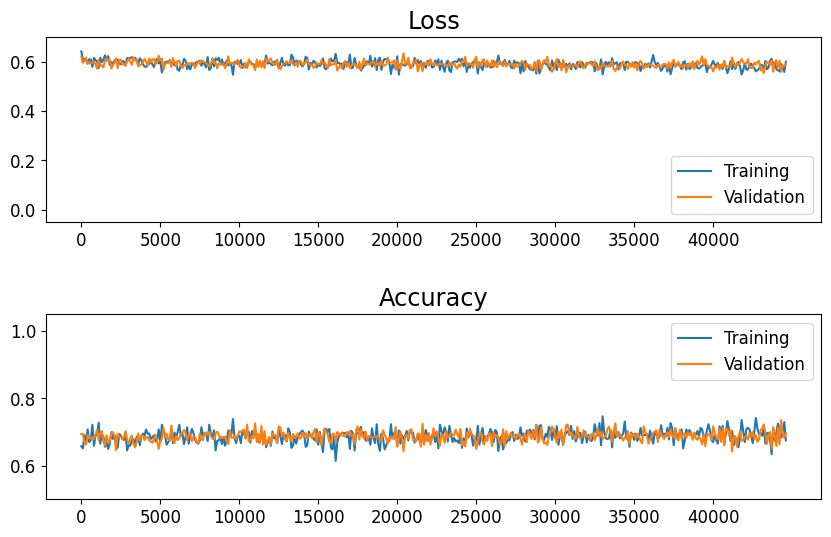

In [5]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(results_train['loss_mean'], label='Training')
axs[0].plot(results_eval['loss_mean'], label='Validation')

axs[0].set_ylim(-0.05, 0.7)

axs[1].plot(results_train['accuracy_mean'], label='Training')
axs[1].plot(results_eval['accuracy_mean'], label='Validation')

axs[1].set_ylim(0.5, 1.05)

x_ticks = [x for x in range(0, len(results_train['loss_mean']), 50)]
x_ticklabels = [x*int(hyperpars['evaluate_every']) for x in x_ticks]

axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(x_ticklabels)

axs[1].set_xticks(x_ticks)
axs[1].set_xticklabels(x_ticklabels)

axs[0].set_title('Loss', size='xx-large')
axs[1].set_title('Accuracy', size='xx-large')

axs[0].tick_params('both', labelsize='large')
axs[1].tick_params('both', labelsize='large')

axs[0].legend(loc='lower right', fontsize='large')
axs[1].legend(loc='upper right', fontsize='large')

fig.subplots_adjust(hspace=0.5)

fig.set_size_inches(10, 6)

fig.savefig('random-pairing-learinng-curves.png', bbox_inches='tight')

In [193]:
test_res = pd.read_csv('{}/test_results_classification.csv'.format(DIRECTORY), index_col=0)

In [194]:
print('Accuracy:    {:.3f}'.format(accuracy_score(test_res['prediction'], test_res['label'])))
print('F1:          {:.3f}'.format(f1_score(test_res['prediction'], test_res['label'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(test_res['prediction'], test_res['label'])))

Accuracy:    0.685
F1:          0.640
MCC:         0.382


In [195]:
val_logits = pd.read_csv('{}/{}'.format(DIRECTORY, 'logits_val.csv'), index_col=0)

In [208]:
val_logits

,heavy_id,light_id,logits,labels
0,89210,9,0.160559,1
1,1467429,38,0.221621,1
2,789270,1191,0.143645,1
3,1572203,680699,0.947593,1
4,364465,367,0.092297,1
...,...,...,...,...
542461,1319747,19321,0.037684,0
542462,1289926,283618,0.040375,0
542463,749832,303529,-0.780617,0
542464,1042967,440786,1.019127,0


,heavy_id,light_id,logits,labels
0,89210,9,0.160559,1
1,1467429,38,0.221621,1
2,789270,1191,0.143645,1
3,1572203,680699,0.947593,1
4,364465,367,0.092297,1
...,...,...,...,...
542461,1319747,19321,0.037684,0
542462,1289926,283618,0.040375,0
542463,749832,303529,-0.780617,0
542464,1042967,440786,1.019127,0


In [196]:
fpr_val_random, tpr_val_random, _ = roc_curve(val_logits['labels'], val_logits['logits'])

AUC: 0.785


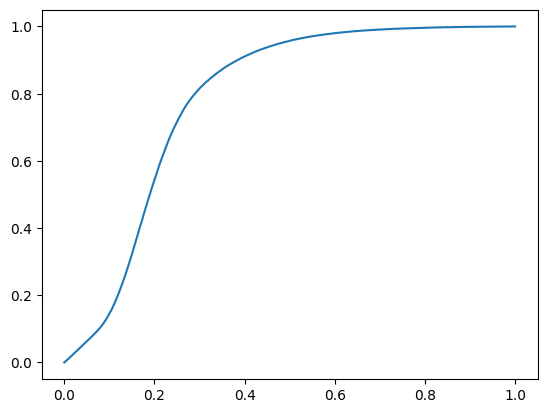

In [197]:
fig, ax = plt.subplots(1)

ax.plot(fpr_val_random, tpr_val_random)

print('AUC: {:.3f}'.format(roc_auc_score(val_logits['labels'], val_logits['logits'])))

In [198]:
metrics = {
    'mcc': matthews_corrcoef,
    'accuracy': accuracy_score,
    'f1': f1_score
}

metrics_results = {
    'mcc': [],
    'accuracy': [],
    'f1': []
}

min_logit = val_logits['logits'].min()
max_logit = val_logits['logits'].max()
thresholds = np.linspace(min_logit, max_logit, 200)

for x in thresholds:
    predicted_class = val_logits['logits'] > x
    true_class = val_logits['labels']

    for m in metrics:
        metrics_results[m].append(metrics[m](true_class, predicted_class))

In [200]:
min_logit

-2.3334665

In [201]:
max_logit

1.7888901

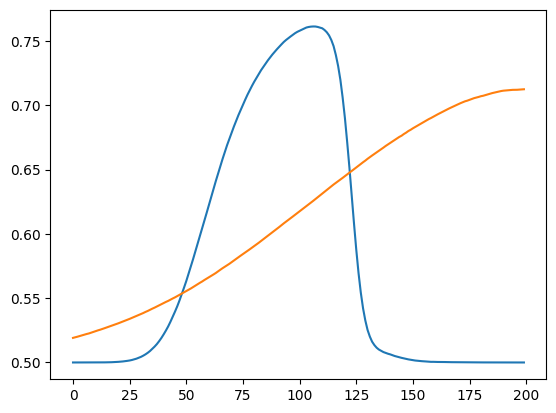

In [207]:
fig, ax = plt.subplots(1)

ax.plot(metrics_results['accuracy'])
ax.plot(metrics_results_dict['random']['accuracy'])


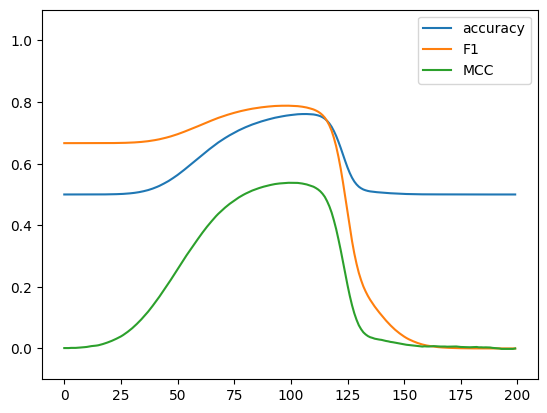

In [199]:
fig, ax = plt.subplots(1)

ax.plot(metrics_results['accuracy'], label='accuracy')
ax.plot(metrics_results['f1'], label='F1')
ax.plot(metrics_results['mcc'], label='MCC')

ax.set_ylim(-0.1, 1.1)

ax.legend()

fig.savefig('random-pairing-acc-f1-mcc.png', bbox_inches='tight')

In [79]:
threshold_random = thresholds[np.argmax(metrics_results['mcc'])]

In [80]:
predicted = val_logits['logits'] > threshold_random

print('Accuracy:    {:.3f}'.format(accuracy_score(predicted, val_logits['labels'])))
print('F1:          {:.3f}'.format(f1_score(predicted, val_logits['labels'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(predicted, val_logits['labels'])))

Accuracy:    0.757
F1:          0.788
MCC:         0.538


In [81]:
test_logits = pd.read_csv('{}/{}'.format(DIRECTORY, 'logits_test.csv'), index_col=0)

In [82]:
fpr_test_random, tpr_test_random, _ = roc_curve(test_logits['labels'], test_logits['logits'])

AUC: 0.791


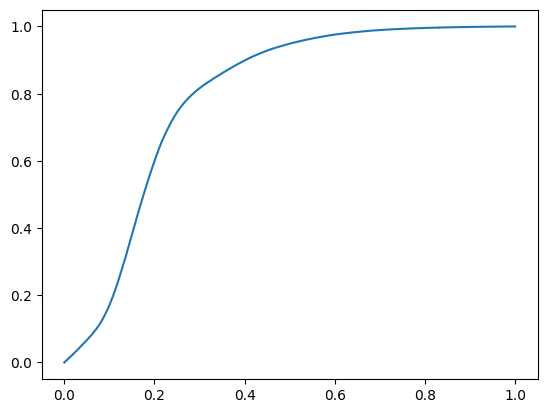

In [83]:
fig, ax = plt.subplots(1)

ax.plot(fpr_test_random, tpr_test_random)

print('AUC: {:.3f}'.format(roc_auc_score(test_logits['labels'], test_logits['logits'])))

In [84]:
predicted = test_logits['logits'] > threshold_random

print('Accuracy:    {:.3f}'.format(accuracy_score(predicted, test_logits['labels'])))
print('F1:          {:.3f}'.format(f1_score(predicted, test_logits['labels'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(predicted, test_logits['labels'])))

Accuracy:    0.748
F1:          0.782
MCC:         0.522


### Final train, germline v

In [16]:
### Final model, random
DIRECTORY = r'../results/classification/final_train_21' 
#DIRECTORY = r'../results/classification/IgBert/long_training'

In [17]:
results_train = pd.read_csv('{}/results_train.csv'.format(DIRECTORY), index_col=0)
results_eval = pd.read_csv('{}/results_eval.csv'.format(DIRECTORY), index_col=0)

In [18]:
with open('{}/hyperpar.json'.format(DIRECTORY)) as f:
    hyperpars = json.load(f)

print('Training dataset:    {}'.format(hyperpars['train_dataset']['name']))
print('Size of the dataset: {}'.format(hyperpars['train_dataset']['size']))
print('    Subsample:       {}'.format(hyperpars['train_dataset']['subsample']))
print('    Frac:            {}'.format(hyperpars['train_dataset']['frac']))
print()
print('Validation dataset:  {}'.format(hyperpars['val_dataset']['name']))
print('Size of the dataset: {}'.format(hyperpars['val_dataset']['size']))
print('    Subsample:       {}'.format(hyperpars['val_dataset']['subsample']))
print('    Frac:            {}'.format(hyperpars['val_dataset']['frac']))
print()
print('Model:               {}'.format(hyperpars['model']['name']))
print('    Checkpoint:      {}'.format(hyperpars['model']['checkpoint']))
print('    N. layers:       {}'.format(hyperpars['model']['number_of_layers']))
print('    Layer size:      {}'.format(hyperpars['model']['layer_size']))
print()
print('Optimizer            {}'.format(hyperpars['optimizer']['name']))
print('    Lr:              {}'.format(hyperpars['optimizer']['lr']))
print('    Weight decay:    {}'.format(hyperpars['optimizer']['weight_decay']))
print('    Beta1:           {}'.format(hyperpars['optimizer']['beta1']))
print('    Beta2:           {}'.format(hyperpars['optimizer']['beta2']))
print()
#print('Scheduler            {}'.format(hyperpars['lr_sched']['name']))
#print('    Start factor:    {}'.format(hyperpars['lr_sched']['start_factor']))
#print('    End factor:      {}'.format(hyperpars['lr_sched']['end_factor']))
#print('    Tot. iters:      {}'.format(hyperpars['lr_sched']['total_iters']))
print()
print('N. epochs            {}'.format(hyperpars['n_epochs']))
print('Train batches:       {}'.format(hyperpars['train_batches']))
print('Eval batches:        {}'.format(hyperpars['eval_batches']))
print('Evaluate every:      {}'.format(hyperpars['evaluate_every']))
print('Mean last:           {}'.format(hyperpars['mean_last']))
print()
print('Note! Batch size: 32')

Training dataset:    ../datasets/new/classificator/germline_v/train_only_v/train_only_v.csv
Size of the dataset: 1432650
    Subsample:       None
    Frac:            None

Validation dataset:  ../datasets/new/classificator/germline_v/val_only_v/val_only_v.csv
Size of the dataset: 542466
    Subsample:       None
    Frac:            None

Model:               average
    Checkpoint:      Exscientia/IgBert
    N. layers:       3
    Layer size:      2048

Optimizer            adam
    Lr:              0.0001
    Weight decay:    0.0001
    Beta1:           0.9
    Beta2:           0.999


N. epochs            1
Train batches:       None
Eval batches:        30
Evaluate every:      100
Mean last:           20

Note! Batch size: 32


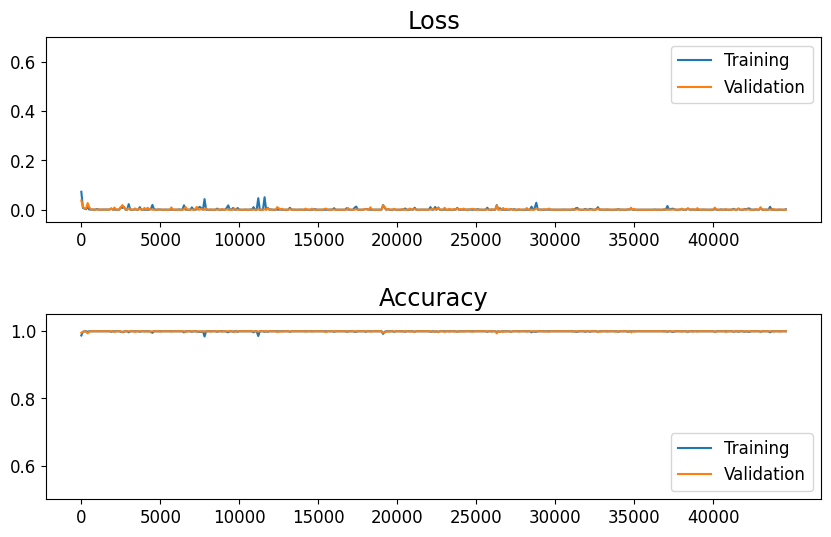

In [19]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(results_train['loss_mean'], label='Training')
axs[0].plot(results_eval['loss_mean'], label='Validation')

axs[0].set_ylim(-0.05, 0.7)

axs[1].plot(results_train['accuracy_mean'], label='Training')
axs[1].plot(results_eval['accuracy_mean'], label='Validation')

axs[1].set_ylim(0.5, 1.05)

x_ticks = [x for x in range(0, len(results_train['loss_mean']), 50)]
x_ticklabels = [x*int(hyperpars['evaluate_every']) for x in x_ticks]

axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(x_ticklabels)

axs[1].set_xticks(x_ticks)
axs[1].set_xticklabels(x_ticklabels)

axs[0].set_title('Loss', size='xx-large')
axs[1].set_title('Accuracy', size='xx-large')

axs[0].tick_params('both', labelsize='large')
axs[1].tick_params('both', labelsize='large')

axs[0].legend(loc='upper right', fontsize='large')
axs[1].legend(loc='lower right', fontsize='large')

fig.subplots_adjust(hspace=0.5)

fig.set_size_inches(10, 6)

fig.savefig('germline_v-pairing-learinng-curves.png', bbox_inches='tight')

In [89]:
test_res = pd.read_csv('{}/test_results_classification.csv'.format(DIRECTORY), index_col=0)

In [90]:
print('Accuracy:    {:.3f}'.format(accuracy_score(test_res['prediction'], test_res['label'])))
print('F1:          {:.3f}'.format(f1_score(test_res['prediction'], test_res['label'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(test_res['prediction'], test_res['label'])))

Accuracy:    0.980
F1:          0.980
MCC:         0.961


In [91]:
val_logits = pd.read_csv('{}/{}'.format(DIRECTORY, 'logits_val.csv'), index_col=0)

In [92]:
fpr_val_germline_v, tpr_val_germline_v, _ = roc_curve(val_logits['labels'], val_logits['logits'])

AUC: 0.723


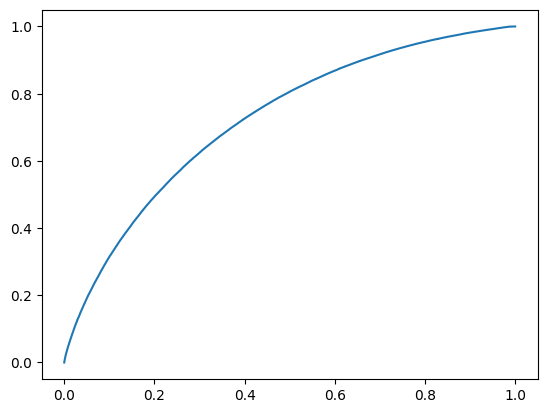

In [93]:
fig, ax = plt.subplots(1)

ax.plot(fpr_val_germline_v, tpr_val_germline_v)

print('AUC: {:.3f}'.format(roc_auc_score(val_logits['labels'], val_logits['logits'])))

In [94]:
metrics = {
    'mcc': matthews_corrcoef,
    'accuracy': accuracy_score,
    'f1': f1_score
}

metrics_results = {
    'mcc': [],
    'accuracy': [],
    'f1': []
}

min_logit = val_logits['logits'].min()
max_logit = val_logits['logits'].max()
thresholds = np.linspace(min_logit, max_logit, 200)

for x in thresholds:
    predicted_class = val_logits['logits'] > x
    true_class = val_logits['labels']

    for m in metrics:
        metrics_results[m].append(metrics[m](true_class, predicted_class))

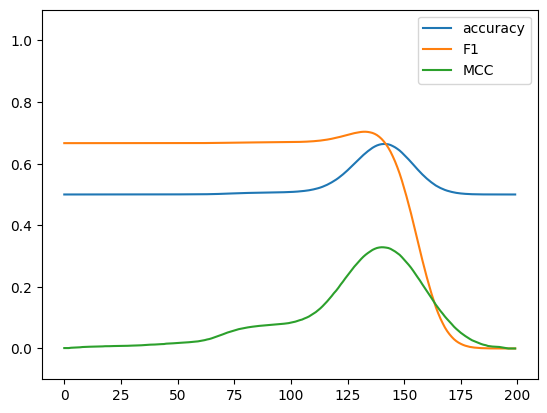

In [95]:
fig, ax = plt.subplots(1)

ax.plot(metrics_results['accuracy'], label='accuracy')
ax.plot(metrics_results['f1'], label='F1')
ax.plot(metrics_results['mcc'], label='MCC')

ax.set_ylim(-0.1, 1.1)

ax.legend()

fig.savefig('germline-v-pairing-acc-f1-mcc.png', bbox_inches='tight')

In [96]:
threshold_germline_v = thresholds[np.argmax(metrics_results['mcc'])]

In [97]:
predicted = val_logits['logits'] > threshold_germline_v

print('Accuracy:    {:.3f}'.format(accuracy_score(predicted, val_logits['labels'])))
print('F1:          {:.3f}'.format(f1_score(predicted, val_logits['labels'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(predicted, val_logits['labels'])))

Accuracy:    0.663
F1:          0.681
MCC:         0.329


In [98]:
test_logits = pd.read_csv('{}/{}'.format(DIRECTORY, 'logits_test.csv'), index_col=0)

In [99]:
fpr_test_germline_v, tpr_test_germline_v, _ = roc_curve(test_logits['labels'], test_logits['logits'])

AUC: 0.739


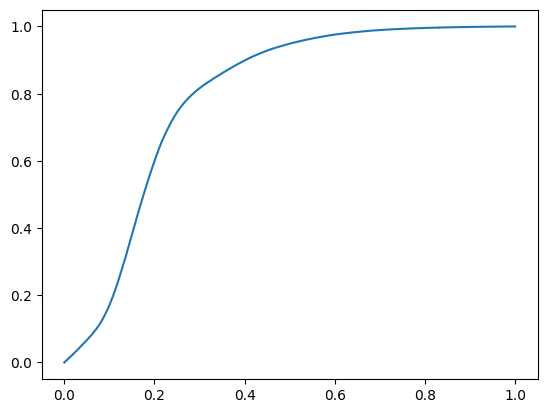

In [100]:
fig, ax = plt.subplots(1)

ax.plot(fpr_test_random, tpr_test_random)

print('AUC: {:.3f}'.format(roc_auc_score(test_logits['labels'], test_logits['logits'])))

In [101]:
predicted = test_logits['logits'] > threshold_germline_v

In [102]:
print('Accuracy:    {:.3f}'.format(accuracy_score(predicted, test_logits['labels'])))
print('F1:          {:.3f}'.format(f1_score(predicted, test_logits['labels'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(predicted, test_logits['labels'])))

Accuracy:    0.679
F1:          0.688
MCC:         0.358


### Final train, germline

In [10]:
DIRECTORY = r'../results/classification/final_train_1' 
#DIRECTORY = r'../results/classification/IgBert/long_training'

In [11]:
results_train = pd.read_csv('{}/results_train.csv'.format(DIRECTORY), index_col=0)
results_eval = pd.read_csv('{}/results_eval.csv'.format(DIRECTORY), index_col=0)

In [12]:
with open('{}/hyperpar.json'.format(DIRECTORY)) as f:
    hyperpars = json.load(f)

print('Training dataset:    {}'.format(hyperpars['train_dataset']['name']))
print('Size of the dataset: {}'.format(hyperpars['train_dataset']['size']))
print('    Subsample:       {}'.format(hyperpars['train_dataset']['subsample']))
print('    Frac:            {}'.format(hyperpars['train_dataset']['frac']))
print()
print('Validation dataset:  {}'.format(hyperpars['val_dataset']['name']))
print('Size of the dataset: {}'.format(hyperpars['val_dataset']['size']))
print('    Subsample:       {}'.format(hyperpars['val_dataset']['subsample']))
print('    Frac:            {}'.format(hyperpars['val_dataset']['frac']))
print()
print('Model:               {}'.format(hyperpars['model']['name']))
print('    Checkpoint:      {}'.format(hyperpars['model']['checkpoint']))
print('    N. layers:       {}'.format(hyperpars['model']['number_of_layers']))
print('    Layer size:      {}'.format(hyperpars['model']['layer_size']))
print()
print('Optimizer            {}'.format(hyperpars['optimizer']['name']))
print('    Lr:              {}'.format(hyperpars['optimizer']['lr']))
print('    Weight decay:    {}'.format(hyperpars['optimizer']['weight_decay']))
print('    Beta1:           {}'.format(hyperpars['optimizer']['beta1']))
print('    Beta2:           {}'.format(hyperpars['optimizer']['beta2']))
print()
print('Scheduler            {}'.format(hyperpars['lr_sched']['name']))
print('    Start factor:    {}'.format(hyperpars['lr_sched']['start_factor']))
print('    End factor:      {}'.format(hyperpars['lr_sched']['end_factor']))
print('    Tot. iters:      {}'.format(hyperpars['lr_sched']['total_iters']))
print()
print('N. epochs            {}'.format(hyperpars['n_epochs']))
print('Train batches:       {}'.format(hyperpars['train_batches']))
print('Eval batches:        {}'.format(hyperpars['eval_batches']))
print('Evaluate every:      {}'.format(hyperpars['evaluate_every']))
print('Mean last:           {}'.format(hyperpars['mean_last']))
print()
print('Note! Batch size: 32')

Training dataset:    ../datasets/new/classificator/germline_all/train/train.csv
Size of the dataset: 1432650
    Subsample:       None
    Frac:            None

Validation dataset:  ../datasets/new/classificator/germline_all/val/val.csv
Size of the dataset: 542466
    Subsample:       None
    Frac:            None

Model:               average
    Checkpoint:      Exscientia/IgBert
    N. layers:       5
    Layer size:      2048

Optimizer            adam
    Lr:              0.0001
    Weight decay:    0.001
    Beta1:           0.95
    Beta2:           0.96

Scheduler            linear
    Start factor:    1
    End factor:      0.1
    Tot. iters:      1000

N. epochs            1
Train batches:       None
Eval batches:        30
Evaluate every:      100
Mean last:           20

Note! Batch size: 32


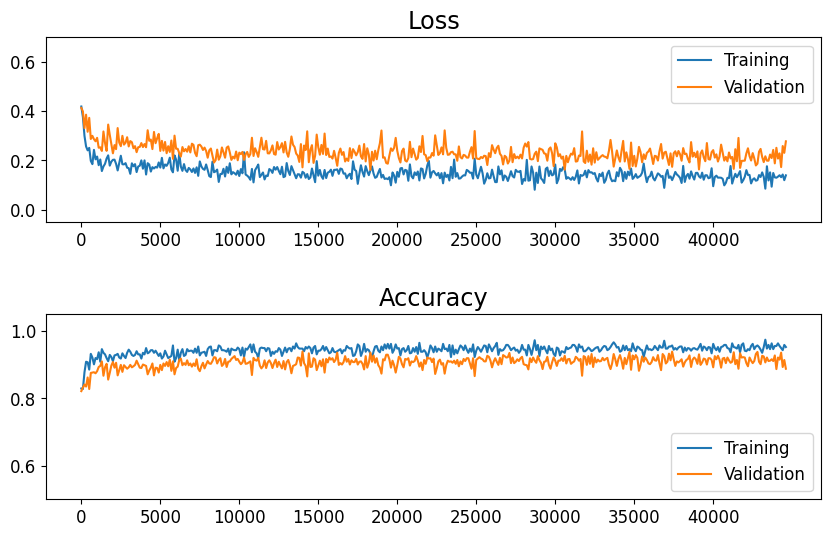

In [14]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(results_train['loss_mean'], label='Training')
axs[0].plot(results_eval['loss_mean'], label='Validation')

axs[0].set_ylim(-0.05, 0.7)

axs[1].plot(results_train['accuracy_mean'], label='Training')
axs[1].plot(results_eval['accuracy_mean'], label='Validation')

axs[1].set_ylim(0.5, 1.05)

x_ticks = [x for x in range(0, len(results_train['loss_mean']), 50)]
x_ticklabels = [x*int(hyperpars['evaluate_every']) for x in x_ticks]

axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(x_ticklabels)

axs[1].set_xticks(x_ticks)
axs[1].set_xticklabels(x_ticklabels)

axs[0].set_title('Loss', size='xx-large')
axs[1].set_title('Accuracy', size='xx-large')

axs[0].tick_params('both', labelsize='large')
axs[1].tick_params('both', labelsize='large')

axs[0].legend(loc='upper right', fontsize='large')
axs[1].legend(loc='lower right', fontsize='large')

fig.subplots_adjust(hspace=0.5)

fig.set_size_inches(10, 6)

fig.savefig('germline-pairing-learinng-curves.png', bbox_inches='tight')

In [107]:
test_res = pd.read_csv('{}/test_results_classification.csv'.format(DIRECTORY), index_col=0)

In [108]:
print('Accuracy:    {:.3f}'.format(accuracy_score(test_res['prediction'], test_res['label'])))
print('F1:          {:.3f}'.format(f1_score(test_res['prediction'], test_res['label'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(test_res['prediction'], test_res['label'])))

Accuracy:    0.924
F1:          0.923
MCC:         0.849


In [109]:
val_logits = pd.read_csv('{}/{}'.format(DIRECTORY, 'logits_val.csv'), index_col=0)

In [110]:
fpr_val_germline, tpr_val_germline, _ = roc_curve(val_logits['labels'], val_logits['logits'])

AUC: 0.785


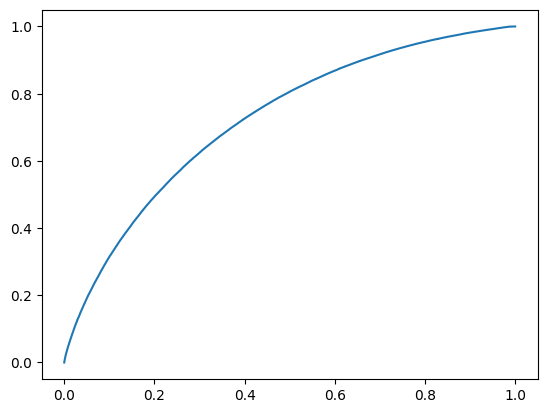

In [111]:
fig, ax = plt.subplots(1)

ax.plot(fpr_val_germline_v, tpr_val_germline_v)

print('AUC: {:.3f}'.format(roc_auc_score(val_logits['labels'], val_logits['logits'])))

In [112]:
metrics = {
    'mcc': matthews_corrcoef,
    'accuracy': accuracy_score,
    'f1': f1_score
}

metrics_results = {
    'mcc': [],
    'accuracy': [],
    'f1': []
}

min_logit = val_logits['logits'].min()
max_logit = val_logits['logits'].max()
thresholds = np.linspace(min_logit, max_logit, 200)

for x in thresholds:
    predicted_class = val_logits['logits'] > x
    true_class = val_logits['labels']

    for m in metrics:
        metrics_results[m].append(metrics[m](true_class, predicted_class))

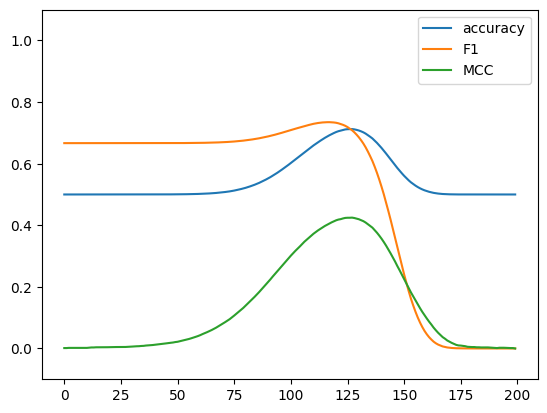

In [113]:
fig, ax = plt.subplots(1)

ax.plot(metrics_results['accuracy'], label='accuracy')
ax.plot(metrics_results['f1'], label='F1')
ax.plot(metrics_results['mcc'], label='MCC')

ax.set_ylim(-0.1, 1.1)

ax.legend()

fig.savefig('germline-pairing-acc-f1-mcc.png', bbox_inches='tight')

In [114]:
threshold_germline = thresholds[np.argmax(metrics_results['mcc'])]

In [115]:
predicted = val_logits['logits'] > threshold_germline

print('Accuracy:    {:.3f}'.format(accuracy_score(predicted, val_logits['labels'])))
print('F1:          {:.3f}'.format(f1_score(predicted, val_logits['labels'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(predicted, val_logits['labels'])))

Accuracy:    0.712
F1:          0.709
MCC:         0.425


In [116]:
test_logits = pd.read_csv('{}/{}'.format(DIRECTORY, 'logits_test.csv'), index_col=0)

In [117]:
fpr_test_germline, tpr_test_germline, _ = roc_curve(test_logits['labels'], test_logits['logits'])

AUC: 0.813


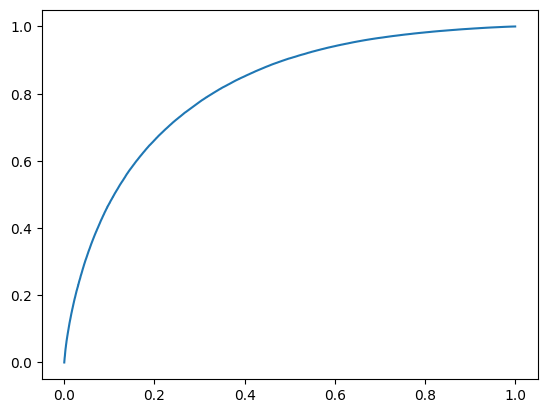

In [124]:
fig, ax = plt.subplots(1)

ax.plot(fpr_test_germline, tpr_test_germline)

print('AUC: {:.3f}'.format(roc_auc_score(test_logits['labels'], test_logits['logits'])))

In [125]:
predicted = test_logits['logits'] > threshold_germline

In [126]:
print('Accuracy:    {:.3f}'.format(accuracy_score(predicted, test_logits['labels'])))
print('F1:          {:.3f}'.format(f1_score(predicted, test_logits['labels'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(predicted, test_logits['labels'])))

Accuracy:    0.735
F1:          0.724
MCC:         0.471


### Comparison

In [38]:
DIRECTORY_RANDOM = r'../results/classification/final_train_11'
DIRECTORY_GERMLINE_V = r'../results/classification/final_train_21'
DIRECTORY_GERMLINE = r'../results/classification/final_train_1'

DIRECTORIES = [DIRECTORY_RANDOM, DIRECTORY_GERMLINE_V, DIRECTORY_GERMLINE]

MODELS = ['random', 'germline_v', 'germline']

In [114]:
def plot_confusion_matrix(y_true, y_pred, ax):
    tp, fp, fn, tn = cf_values(y_true, y_pred)

    cf = [[tp, fn],
          [fp, tn]]

    ax.imshow(cf, vmax=tp+fp+fn+tn, vmin=0)
    ax.text(0, 0, '{:,}'.format(cf[0][0]), 
                ha='center', va='center', fontsize=20)
    ax.text(1, 0, '{:,}'.format(cf[0][1]), 
                ha='center', va='center', fontsize=20)
    ax.text(0, 1, '{:,}'.format(cf[1][0]), 
                ha='center', va='center', fontsize=20)
    ax.text(1, 1, '{:,}'.format(cf[1][1]), 
                ha='center', va='center', fontsize=20)
    ax.tick_params(which='both', bottom=False, top=False, left=False, right=False)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Real Positive', 'Real Negative'], rotation=90,
                       va='center', fontsize=15)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Pred. Positive', 'Pred. Negative'],
                       ha='center', fontsize=15)

def print_single_roc_curve(labels, logits, ax, label):
    fpr, tpr, _ = roc_curve(labels, logits)
    ax.plot(fpr, tpr, label=label)

def print_roc_curve(logits_dict, ax):
    for n, df in logits_dict.items():
        print_single_roc_curve(df['labels'], df['logits'], ax, n)

def print_auc(logits_dict):
    models_name = logits_dict.keys()
    print('|{:^13}|{:^13}|{:^13}|{:^13}|'.format(*[n for n in models_name]))
    print('|{:12.4f} |{:12.4f} |{:12.4f} |{:12.4f} |'.format(*[
        roc_auc_score(logits_dict[n]['labels'], logits_dict[n]['logits']) 
        for n in models_name]))

def get_metrics_results_dict(logits_dict):
    metrics = {
        'mcc': matthews_corrcoef,
        'accuracy': accuracy_score,
        'f1': f1_score,
    }

    metrics_results_dict = {}
    data = {}

    for n, df in logits_dict.items():
        metrics_results_dict[n] = {m: [] for m in metrics}
        data[n] = {}

        min_logit = 0#df['logits'].min()
        max_logit = 1#df['logits'].max()
        thresholds = np.linspace(min_logit, max_logit, 200)

        for x in thresholds:
            predicted_class = df['logits'] > x
            true_class = df['labels']

            for m in metrics:
                metrics_results_dict[n][m].append(metrics[m](true_class, predicted_class))
        
        data[n]['min_logit'] = min_logit
        data[n]['max_logit'] = max_logit
        data[n]['threshold_index'] = np.argmax(metrics_results_dict[n]['mcc'])
        data[n]['threshold'] = thresholds[np.argmax(metrics_results_dict[n]['mcc'])]

    return metrics_results_dict, data

def print_test_results(logits_dict, data, metrics):
    d = {}
    for name, df in logits_dict.items():
        predicted = df['logits'] > 0#data[name]['threshold']
        d[name] = {}

        for m, function in metrics.items():
            d[name][m] = function(df['labels'], predicted)

    print('|{:13}|{:^13}|{:^13}|{:^13}|{:^13}|'.format('', *[n for n in logits_dict]))
    for m in metrics:
        print('|{:13}|{:12.4f} |{:12.4f} |{:12.4f} |{:12.4f} |'.format(m, *[d[n][m] for n in logits_dict]))

In [40]:
dirs_dict = {
    m: d for m, d in zip(MODELS, DIRECTORIES)
}

In [12]:

# 1 true positive
# 2 false positive
# 3 false negative
# 4 true negative
#predictions = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
#labels =      [1, 0, 0, 1, 1, 1, 0, 0, 0, 0]

#fig, ax = plt.subplots(1)
#plot_confusion_matrix(labels, predictions, ax)



Test set results
|             |   random    | germline_v  |  germline   |
|precision    |      0.6478 |      0.9625 |      0.9085 |
|recall       |      0.8104 |      0.9995 |      0.9434 |
|specificity  |      0.5593 |      0.9611 |      0.9050 |
|accuracy     |      0.6849 |      0.9803 |      0.9242 |
|f1           |      0.7200 |      0.9807 |      0.9256 |
|mcc          |      0.3820 |      0.9613 |      0.8490 |


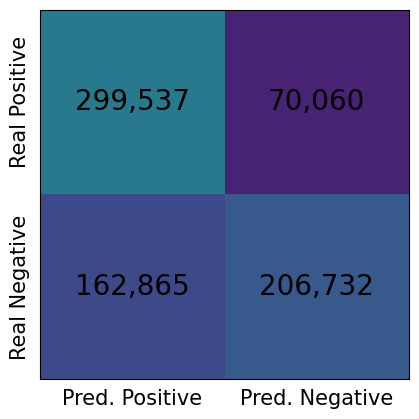

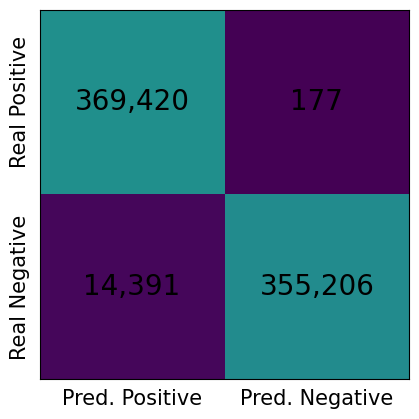

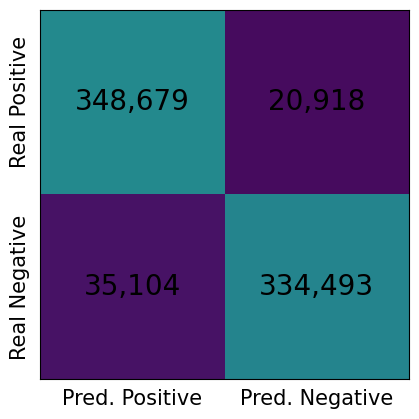

In [41]:
def print_test_set_results(dirs_dict, metrics):
    d = {}
    for name, dir in dirs_dict.items():
        d[name] = {}
        test_res = pd.read_csv('{}/test_results_classification.csv'.format(dir), index_col=0)
        
        predictions = test_res['prediction']
        labels = test_res['label']

        invert_class = lambda x: 1 if x == 0 else 0
        predictions = predictions.map(invert_class)
        labels = labels.map(invert_class)
        
        d[name]['predictions'] = predictions
        d[name]['labels'] = labels

        for metric, function in metrics.items():
            d[name][metric] = function(labels, predictions)
      
    print('|{:13}|{:^13}|{:^13}|{:^13}|'.format('', *[n for n in dirs_dict]))
    for m in metrics:
        print('|{:13}|{:12.4f} |{:12.4f} |{:12.4f} |'.format(m, *[d[n][m] for n in dirs_dict]))

    for m in d:
        fig, ax = plt.subplots(1)
        plot_confusion_matrix(d[m]['labels'], d[m]['predictions'], ax)
        fig.savefig('{}-conf-matrix-test-set.png'.format(m), bbox_inches='tight')
        

print('Test set results')
print_test_set_results(dirs_dict, metrics)

In [140]:
val_logits_dict = {
    n: pd.read_csv('{}/{}'.format(d, 'logits_val.csv'), index_col=0)
    for n, d in dirs_dict.items()
}
val_logits_dict['random']['logits'] = val_logits_dict['random']['logits'].map(expit)
val_logits_dict['germline_v']['logits'] = val_logits_dict['germline_v']['logits'].map(expit)
val_logits_dict['germline']['logits'] = val_logits_dict['germline']['logits'].map(expit)

test_logits_dict = {
    n: pd.read_csv('{}/{}'.format(d, 'logits_test.csv'), index_col=0)
    for n, d in dirs_dict.items()
}
test_logits_dict['random']['logits'] = test_logits_dict['random']['logits'].map(expit)
test_logits_dict['germline_v']['logits'] = test_logits_dict['germline_v']['logits'].map(expit)
test_logits_dict['germline']['logits'] = test_logits_dict['germline']['logits'].map(expit)

In [104]:
metrics_results_dict, data = get_metrics_results_dict(val_logits_dict)

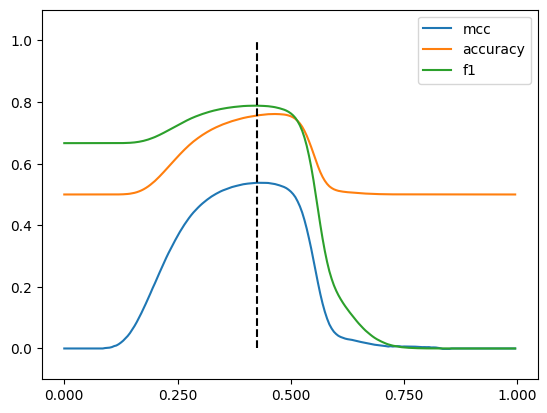

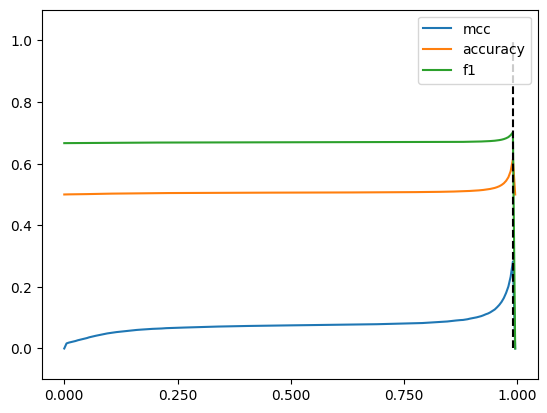

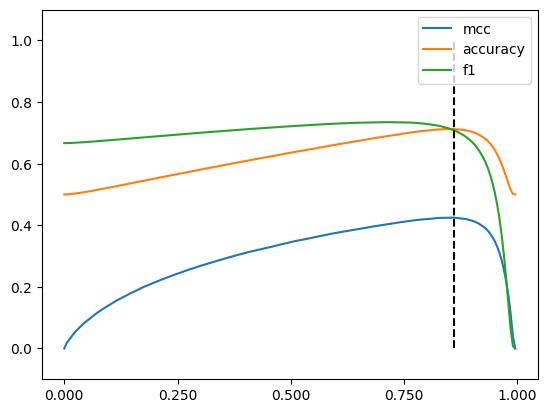

In [105]:
def plot_metric_curves(metrics, data, ax):
    for m, values in metrics.items():
        ax.plot(values, label=m)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xticks(np.linspace(0, len(values), 5))
    ax.set_xticklabels(['{:.3f}'.format(x) for x in
                        np.linspace(data['min_logit'], data['max_logit'], 5)])
    
    ax.vlines(data['threshold_index'], 0, 1, colors='k', linestyles='--')


for m, values in metrics_results_dict.items():
    fig, ax = plt.subplots(1)
    plot_metric_curves(values, data[m], ax)
    ax.legend()

    fig.savefig('{}-metric-curves.png'.format(m), bbox_inches='tight')

In [141]:
def subtract_threshold(df, threshold):
    df['logits'] = df['logits'] - threshold
    return df

for key, df in val_logits_dict.items():
    val_logits_dict[key] = subtract_threshold(df, data[key]['threshold'])

In [142]:
def get_ensamble(logits_dict):
    df = logits_dict['random']
    #random_pos = df[df['labels'] == 1].sort_values(by='heavy_id')
    #random_neg = df[df['labels'] == 0].sort_values(by='heavy_id')

    df = logits_dict['germline']
    #germline_pos = df[df['labels'] == 1].sort_values(by='heavy_id')
    #germline_neg = df[df['labels'] == 0].sort_values(by='heavy_id')

    merged = pd.merge(logits_dict['random'], logits_dict['germline'],
                      on=['heavy_id', 'light_id', 'labels'])
    logits = merged[['logits_x', 'logits_y']]
    logits = logits.apply(lambda row: 
                          row['logits_x'] if abs(row['logits_x']) > abs(row['logits_y']) else row['logits_y'], 
                          axis=1)
    merged = pd.concat([merged, logits], axis=1)
    merged = merged.rename({0: 'logits'}, axis=1)
    return merged[['heavy_id', 'light_id', 'logits', 'labels']]

    #merged_pos = random_pos.merge(germline_pos, on=['heavy_id'])
    #merged_neg = random_neg.merge(germline_neg, on=['heavy_id'])

    #logits_pos = merged_pos[['logits_x', 'logits_y']].apply(np.max, axis=1)
    #logits_neg = merged_neg[['logits_x', 'logits_y']].apply(np.min, axis=1)

    #print(logits_pos.head())
    #print(logits_neg.head())

    #merged_pos = merged_pos[['heavy_id'] +
    #                        [c for c in merged_pos.columns if '_x' in c and 'logits' not in c]]
    #merged_neg = merged_neg[['heavy_id'] +
    #                        [c for c in merged_neg.columns if '_x' in c and 'logits' not in c]]
    
    #merged_pos = pd.concat([merged_pos, logits_pos], axis=1)
    #merged_neg = pd.concat([merged_neg, logits_neg], axis=1)
    #merged = pd.concat([merged_pos, merged_neg])
    #merged = merged.rename({
    #    'light_id_x': 'light_id',
    #    'labels_x': 'labels',
    #    0: 'logits'
    #}, axis=1)

    #return merged[['heavy_id', 'light_id', 'logits', 'labels']]

ensamble = get_ensamble(val_logits_dict)

In [143]:
val_logits_dict['ensamble'] = ensamble

|   random    | germline_v  |  germline   |  ensamble   |
|      0.7852 |      0.7227 |      0.7846 |      0.7878 |


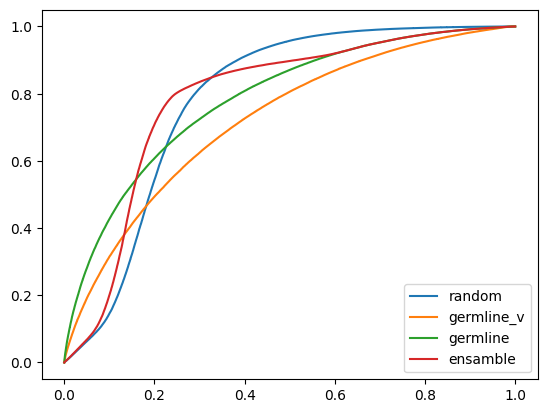

In [144]:
fig, ax = plt.subplots(1)

print_roc_curve(val_logits_dict, ax)

ax.legend(loc='lower right')

print_auc(val_logits_dict)

In [145]:
print('Prediction of the test procedure over the validation dataset')
print_test_results(val_logits_dict, data, metrics)

Prediction of the test procedure over the validation dataset
|             |   random    | germline_v  |  germline   |  ensamble   |
|precision    |      0.6974 |      0.5720 |      0.7179 |      0.7656 |
|recall       |      0.9066 |      0.9080 |      0.6996 |      0.7969 |
|specificity  |      0.6066 |      0.3205 |      0.7251 |      0.7561 |
|accuracy     |      0.7566 |      0.6143 |      0.7124 |      0.7765 |
|f1           |      0.7884 |      0.7018 |      0.7087 |      0.7809 |
|mcc          |      0.5380 |      0.2824 |      0.4249 |      0.5534 |


In [146]:
for key, df in test_logits_dict.items():
    test_logits_dict[key] = subtract_threshold(df, data[key]['threshold'])

In [147]:
ensamble = get_ensamble(test_logits_dict)
test_logits_dict['ensamble'] = ensamble

|   random    | germline_v  |  germline   |  ensamble   |
|      0.7908 |      0.7393 |      0.8129 |      0.8090 |


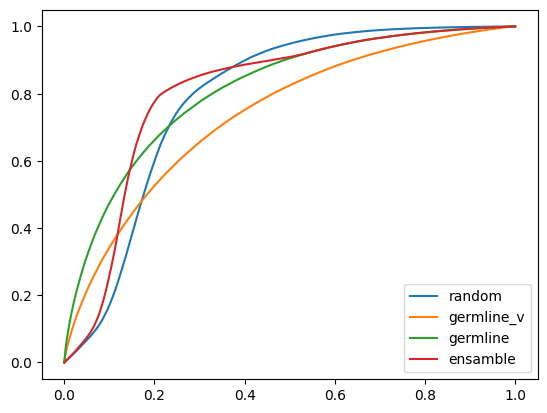

In [148]:
fig, ax = plt.subplots(1)

print_roc_curve(test_logits_dict, ax)

ax.legend(loc='lower right')

print_auc(test_logits_dict)

fig.savefig('roc-mdoels.png'.format(m), bbox_inches='tight')

In [149]:
print('Prediction of the test procedure over the test dataset')
print_test_results(test_logits_dict, data, metrics)

Prediction of the test procedure over the test dataset
|             |   random    | germline_v  |  germline   |  ensamble   |
|precision    |      0.6876 |      0.5839 |      0.7545 |      0.7905 |
|recall       |      0.9071 |      0.9010 |      0.6967 |      0.7934 |
|specificity  |      0.5878 |      0.3578 |      0.7733 |      0.7898 |
|accuracy     |      0.7475 |      0.6294 |      0.7350 |      0.7916 |
|f1           |      0.7822 |      0.7086 |      0.7245 |      0.7919 |
|mcc          |      0.5223 |      0.3083 |      0.4714 |      0.5831 |


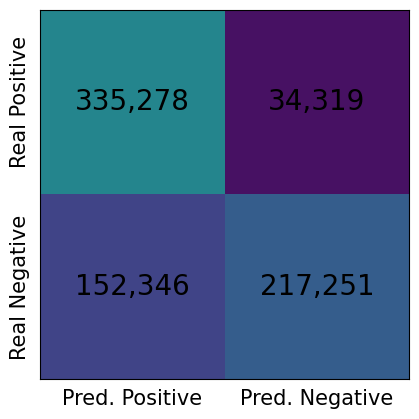

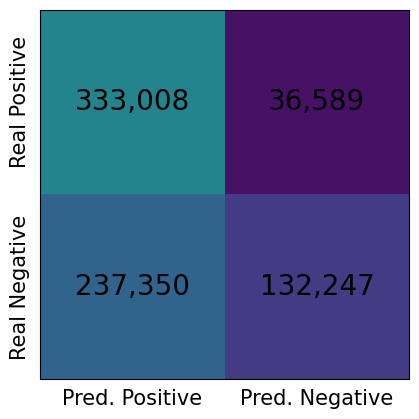

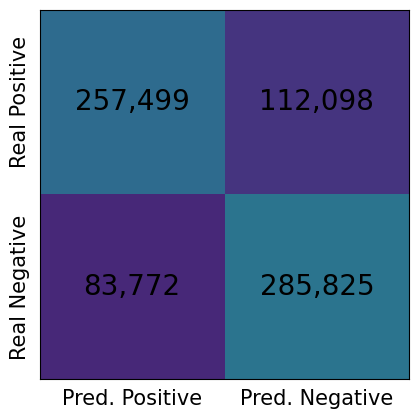

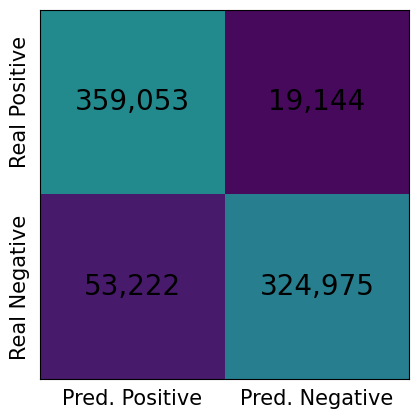

In [118]:
for name, df in test_logits_dict.items():
    fig, ax = plt.subplots(1)
    predicted = df['logits'] > 0
    plot_confusion_matrix(df['labels'], predicted, ax)
    fig.savefig('{}-conf-matrix-test-procedure-png'.format(name), bbox_inches='tight')

In [150]:
data

{'random': {'min_logit': 0,
  'max_logit': 1,
  'threshold_index': 85,
  'threshold': 0.4271356783919598},
 'germline_v': {'min_logit': 0,
  'max_logit': 1,
  'threshold_index': 198,
  'threshold': 0.9949748743718593},
 'germline': {'min_logit': 0,
  'max_logit': 1,
  'threshold_index': 172,
  'threshold': 0.864321608040201}}

### Other datasets

In [43]:
DIRECTORY = r'../results/classification/grid_search_11'

In [44]:
gs_results = defaultdict(dict)

for d in os.listdir(DIRECTORY):
    with open('{}/{}/hyperpar.json'.format(DIRECTORY, d)) as f:
        hyperpars = json.load(f)
    
    gs_results[d]['number_of_layer'] = hyperpars['model']['number_of_layers']
    gs_results[d]['layer_size'] = hyperpars['model']['layer_size']
    gs_results[d]['lr'] = hyperpars['optimizer']['lr']
    gs_results[d]['weight_decay'] = hyperpars['optimizer']['weight_decay']

    #print(hyperpars)

    if 'lr_sched' not in hyperpars:
        gs_results[d]['lr_sched'] = 'None'
        gs_results[d]['start_factor'] = 'None'
        gs_results[d]['end_factor'] = 'None'
        gs_results[d]['total_iters'] = 'None'
    else:
        gs_results[d]['lr_sched'] = hyperpars['lr_sched']['name']
        gs_results[d]['start_factor'] = hyperpars['lr_sched']['start_factor']
        gs_results[d]['end_factor'] = hyperpars['lr_sched']['end_factor']
        gs_results[d]['total_iters'] = hyperpars['lr_sched']['total_iters']

    if 'beta1' in hyperpars['optimizer']:
        gs_results[d]['beta1'] = hyperpars['optimizer']['beta1']
        gs_results[d]['beta2'] = hyperpars['optimizer']['beta2']

In [45]:
for d in os.listdir(DIRECTORY):
    df = pd.read_csv('{}/{}/val_results_classification.csv'.format(DIRECTORY, d), index_col=0)
    gs_results[d]['acc'] = accuracy_score(df['label'], df['prediction'])
    gs_results[d]['f1'] = f1_score(df['label'], df['prediction'])
    gs_results[d]['mcc'] = matthews_corrcoef(df['label'], df['prediction'])

In [46]:
dict_results = defaultdict(list)

for _, item in gs_results.items():
    for key, value in item.items():
        dict_results[key].append(value)

In [47]:
dict_results = defaultdict(list)

for _, item in gs_results.items():
    for key, value in item.items():
        dict_results[key].append(value)

df_results = pd.DataFrame(dict_results)

acc_columns = sorted([c for c in df_results.columns if 'acc' in c])
f1_columns = sorted([c for c in df_results.columns if 'f1' in c])
mcc_columns = sorted([c for c in df_results.columns if 'mcc' in c])
other_columns = sorted(list(set(df_results.columns).difference(set(acc_columns + f1_columns + mcc_columns))))

df_results = df_results[other_columns + acc_columns + f1_columns + mcc_columns]

In [56]:
WHICH = 'f1'
df_results[other_columns + 
           ['{}'.format(WHICH)]].sort_values(by='{}'.format(WHICH), ascending=False)

,beta1,beta2,end_factor,layer_size,lr,lr_sched,number_of_layer,start_factor,total_iters,weight_decay,f1
14,0.9,0.999,None,1024,0.0010,None,5,None,None,0.00001,0.676739
20,0.9,0.999,None,2048,0.0010,None,5,None,None,0.00001,0.668276
19,0.9,0.999,None,2048,0.0010,None,5,None,None,0.00010,0.668276
13,0.9,0.999,None,1024,0.0010,None,5,None,None,0.00010,0.668276
12,0.9,0.999,None,1024,0.0010,None,5,None,None,0.00100,0.665187
1,0.9,0.999,None,1024,0.0010,None,3,None,None,0.00010,0.650029
10,0.9,0.999,None,2048,0.0001,None,3,None,None,0.00010,0.645421
21,0.9,0.999,None,2048,0.0001,None,5,None,None,0.00100,0.643457
17,0.9,0.999,None,1024,0.0001,None,5,None,None,0.00001,0.641608
5,0.9,0.999,None,1024,0.0001,None,3,None,None,0.00001,0.641313


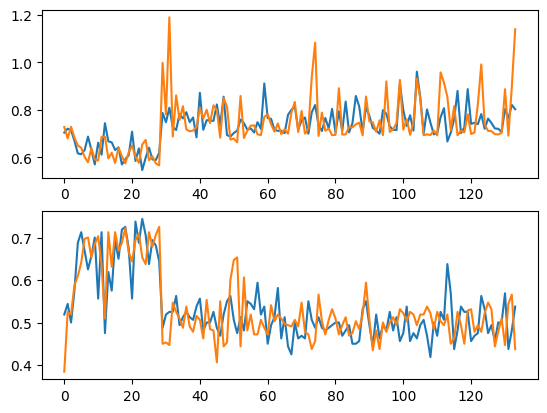

In [54]:
WHICH = 20

fig, axs = plt.subplots(2)

learning_curves_train = pd.read_csv('{}/{}/results_train.csv'.format(DIRECTORY, WHICH), index_col=0)
learning_curves_eval = pd.read_csv('{}/{}/results_eval.csv'.format(DIRECTORY, WHICH), index_col=0)

axs[0].plot(learning_curves_train['loss_mean'])
axs[0].plot(learning_curves_eval['loss_mean'])

axs[1].plot(learning_curves_train['accuracy_mean'])
axs[1].plot(learning_curves_eval['accuracy_mean'])

### Test correlation

In [5]:
WHICH_MODEL = 'final_train_1'
LOCATION = '../results/classification/{}'.format(WHICH_MODEL)

CHECKPOINT = 'Exscientia/IgBert'
MODEL_NAME = 'average'

TOKENIZER_CHECKPOINT = None
if TOKENIZER_CHECKPOINT is None: TOKENIZER_CHECKPOINT = CHECKPOINT

In [11]:
state_dict = torch.load('{}/model.pt'.format(LOCATION), weights_only=True)
model = utils.load_model(MODEL_NAME, checkpoint=CHECKPOINT, state_dict=state_dict)
tokenizer = utils.retrieve_tokenizer(TOKENIZER_CHECKPOINT)

Tokenizer checkpoint: Exscientia/IgBert


In [12]:
df = pd.read_csv('../datasets/functionality-developability-cross_reactivity-data_vh_vl.csv')

In [25]:
id_col = [i for i in range(len(df[['VH', 'VL']]))]
class_col = [0 for i in range(len(df[['VH', 'VL']]))]

data_dict = {
    'pair_id': id_col,
    'heavy': df['VH'].to_numpy(),
    'light': df['VL'].to_numpy(),
    'class': class_col
}

ab_df = pd.DataFrame(data_dict)
data = DataLoader(utils.AbDataset(ab_df), batch_size=32)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

logits_vec = []

model.eval()
with torch.no_grad():
    for batch in tqdm(data, total=len(data)):
        _, inputs, value = batch[0], batch[1], batch[2]
        input_dict = utils.tokenize_inputs(inputs, tokenizer, device=device)
        logits = model(**input_dict)
        logits_vec.append(logits.to('cpu'))

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


In [88]:
logits = torch.stack(list(itertools.chain.from_iterable([x[:, 0] for x in logits_vec]))).numpy()
probs = np.stack(list(itertools.chain.from_iterable([softmax(logits_vec[0], axis=1)[:, 0] for x in logits_vec])))

In [81]:
print(pearsonr(logits, df['KD (nM)'].to_numpy())[0])
print(pearsonr(probs, df['KD (nM)'].to_numpy())[0])

-0.45364675607959637
-0.48488630552251877


In [89]:
print(pearsonr(-np.log(logits), -np.log(df['KD (nM)'].to_numpy()))[0])
print(pearsonr(-np.log(probs), -np.log(df['KD (nM)'].to_numpy()))[0])

-0.3652444349243523
-0.39253019645768455


In [90]:
print(pearsonr(logits[0] - logits[1:], df['Edit distance to trastuzumab'].to_numpy()[1:])[0])
print(pearsonr(probs[0] - probs[1:], df['Edit distance to trastuzumab'].to_numpy()[1:])[0])

-0.42815992502992634
-0.25601089632630714


In [91]:
print(pearsonr(abs(logits[0] - logits[1:]), df['Edit distance to trastuzumab'].to_numpy()[1:])[0])
print(pearsonr(abs(probs[0] - probs[1:]), df['Edit distance to trastuzumab'].to_numpy()[1:])[0])

0.3440380591641787
0.1424564717401281


In [64]:
df['Edit distance to trastuzumab'].to_numpy()

array([ 0.,  9.,  7.,  6., 12.,  7.,  2.,  6.,  7.,  6., 10.,  8.,  9.])

In [79]:
np.stack(probs)

array([0.9721725 , 0.97734785, 0.9734665 , 0.9701591 , 0.9888383 ,
       0.9748048 , 0.9605995 , 0.97170854, 0.9748047 , 0.9321931 ,
       0.9371073 , 0.97855693, 0.97227997], dtype=float32)

# VECCHIO

In [3]:
directories = ['{}/{}'.format(GRID_SEARCH_DIRECTORY, d) for d in os.listdir(GRID_SEARCH_DIRECTORIES[0])]

In [4]:
hyperpars_list = []
for d in directories:
    with open('{}/hyperpar.json'.format(d)) as f:
        hyperpars_list.append(json.load(f))
        print(d, 
              hyperpars_list[-1]['n_epochs'], 
              hyperpars_list[-1]['model']['number_of_layers'],
              hyperpars_list[-1]['model']['layer_size'],
              hyperpars_list[-1]['optimizer']['lr'],
              hyperpars_list[-1]['optimizer']['weight_decay'])

../results/classification/grid_search_1/0 3 3 1024 0.001 0.001
../results/classification/grid_search_1/1 3 3 1024 0.001 0.0001
../results/classification/grid_search_1/2 3 3 1024 0.001 1e-05
../results/classification/grid_search_1/3 3 3 1024 0.0001 0.001
../results/classification/grid_search_1/4 3 3 1024 0.0001 0.0001
../results/classification/grid_search_1/5 3 3 1024 0.0001 1e-05
../results/classification/grid_search_1/6 3 3 2048 0.001 0.001
../results/classification/grid_search_1/7 3 3 2048 0.001 0.0001
../results/classification/grid_search_1/8 3 3 2048 0.001 1e-05
../results/classification/grid_search_1/9 3 3 2048 0.0001 0.001
../results/classification/grid_search_1/10 3 3 2048 0.0001 0.0001
../results/classification/grid_search_1/11 3 3 2048 0.0001 1e-05
../results/classification/grid_search_1/12 3 5 1024 0.001 0.001
../results/classification/grid_search_1/13 3 5 1024 0.001 0.0001
../results/classification/grid_search_1/14 3 5 1024 0.001 1e-05
../results/classification/grid_search_1

In [24]:
learning_curves = defaultdict(list)

for d in directories:
    df_train = pd.read_csv('{}/results_train.csv'.format(d), index_col=0)
    learning_curves['train'].append(df_train)
    df_val = pd.read_csv('{}/results_eval.csv'.format(d), index_col=0)
    learning_curves['eval'].append(df_val)

(0.0, 1.0)

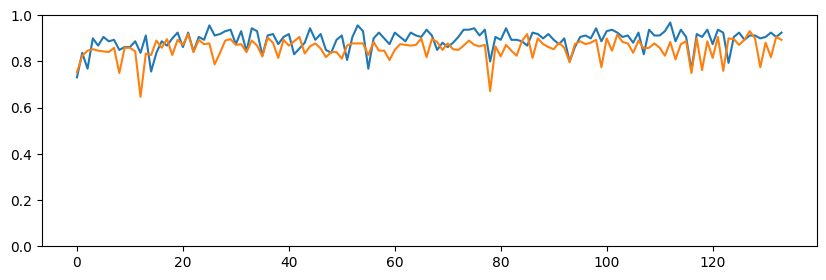

In [27]:
fig, axs = plt.subplots(1)

fig.set_size_inches(10, 3)

i = 4

axs.plot(learning_curves['train'][i]['accuracy_mean'])
axs.plot(learning_curves['eval'][i]['accuracy_mean'])

axs.set_ylim(0.0, 1)

In [15]:
from sklearn.metrics import accuracy_score

for d in directories:
    with open('{}/hyperpar.json'.format(d)) as f:
        hyperpars = json.load(f)
    print(hyperpars['model']['number_of_layers'],
          hyperpars['model']['layer_size'],
          hyperpars['optimizer']['lr'],
          hyperpars['optimizer']['weight_decay'])
    df = pd.read_csv('{}/val_results_classification.csv'.format(d), index_col=0)
    print(accuracy_score(df['label'], df['prediction']))
    print()

3 1024 0.001 0.001
0.9055414224090256

3 1024 0.001 0.0001
0.9014858238395458

3 1024 0.001 1e-05
0.9029605869557202

3 1024 0.0001 0.001
0.8808760092910076

3 1024 0.0001 0.0001
0.9081591269402353

3 1024 0.0001 1e-05
0.9061681967333997

3 2048 0.001 0.001
0.8422003465693323

3 2048 0.001 0.0001
0.9053202079415994

3 2048 0.001 1e-05
0.8788850790841721

3 2048 0.0001 0.001
0.8844154407698264

3 2048 0.0001 0.0001
0.8945175681156214

3 2048 0.0001 1e-05
0.8949968661283781

5 1024 0.001 0.001
0.48999004534896584

5 1024 0.001 0.0001
0.8320244810677285

5 1024 0.001 1e-05
0.8747557423588836

5 1024 0.0001 0.001
0.8885079084172105

5 1024 0.0001 0.0001
0.9055414224090256

5 1024 0.0001 1e-05
0.9021494672418243

5 2048 0.001 0.001
0.8840098809128784

5 2048 0.001 0.0001
0.49717951554031636

5 2048 0.001 1e-05
0.7579913726357704

5 2048 0.0001 0.001
0.9093758065110792

5 2048 0.0001 0.0001
0.9052096007078863



In [26]:
learning_curves['train'][i]['accuracy_mean']

IndexError: list index out of range

In [4]:
RESULTS_DIRECTORY = r'../results/classification/IgBert_only_v/'
GRID_SEARCH_DIRECTORIES = [r'{}/lr_1e-{}'.format(RESULTS_DIRECTORY, i)
                           for i in [2, 3, 4, 5]]
LONG_TRAINING_DIRECTORY = '{}/long_training'.format(RESULTS_DIRECTORY)

### Grid Search

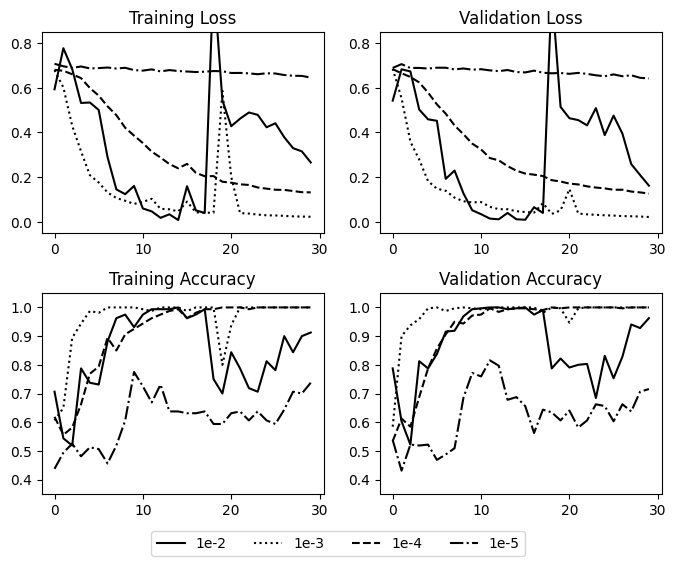

In [5]:
fig, axs = plt.subplots(2, 2)

linestyles = ['solid', 'dotted', 'dashed', 'dashdot']

for i, d in enumerate(GRID_SEARCH_DIRECTORIES):
    train_metrics = pd.read_csv('{}/results_train.csv'.format(d), index_col=0)
    eval_metrics = pd.read_csv('{}/results_eval.csv'.format(d), index_col = 0)

    axs[0, 0].plot(train_metrics['loss_mean'][:30], label='1e-{}'.format(d.split('-')[-1]),
                   color='k', linestyle=linestyles[i])
    axs[0, 0].set_ylim(-0.05, 0.85)
    axs[0, 0].set_title('Training Loss')

    axs[1, 0].plot(train_metrics['accuracy_mean'][:30], label='1e-{}'.format(d.split('-')[-1]),
                   color='k', linestyle=linestyles[i])
    axs[1, 0].set_ylim(0.35, 1.05)
    axs[1, 0].set_title('Training Accuracy')

    axs[0, 1].plot(eval_metrics['loss_mean'][:30], label='1e-{}'.format(d.split('-')[-1]),
                   color='k', linestyle=linestyles[i])
    axs[0, 1].set_ylim(-0.05, 0.85)
    axs[0, 1].set_title('Validation Loss')
    
    axs[1, 1].plot(eval_metrics['accuracy_mean'][:30], label='1e-{}'.format(d.split('-')[-1]),
                   color='k', linestyle=linestyles[i])
    axs[1, 1].set_ylim(0.35, 1.05)
    axs[1, 1].set_title('Validation Accuracy')


fig.set_size_inches(8, 6)
fig.subplots_adjust(hspace=0.3)
h, l = axs[0, 0].get_legend_handles_labels()
fig.legend(h, l, loc=8, ncol=4)#, bbox_to_anchor=[0.5,0])
fig.savefig('learning-curves.png', bbox_inches='tight')

### Long Training

In [54]:
train_metrics = pd.read_csv('{}/results_train.csv'.format(LONG_TRAINING_DIRECTORY), index_col=0)
eval_metrics = pd.read_csv('{}/results_eval.csv'.format(LONG_TRAINING_DIRECTORY), index_col=0)

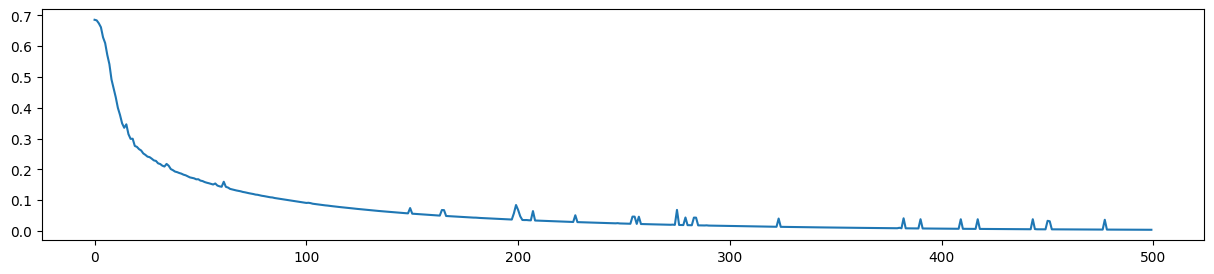

In [55]:
fig, ax = plt.subplots(1)
fig.set_size_inches(15, 3)
ax.plot(train_metrics['loss_mean'])

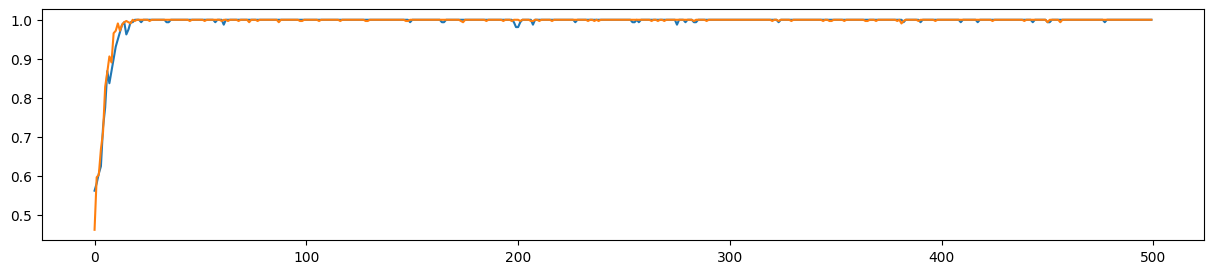

In [56]:
fig, ax = plt.subplots(1)
fig.set_size_inches(15, 3)
ax.plot(train_metrics['accuracy_mean'])
ax.plot(eval_metrics['accuracy_mean'])

### Val Results

In [6]:
val_res = pd.read_csv('{}/val_results_classification.csv'.format(LONG_TRAINING_DIRECTORY), index_col=0)

In [7]:
print('Accuracy:    {:.3f}'.format(accuracy_score(val_res['prediction'], val_res['label'])))
print('F1:          {:.3f}'.format(f1_score(val_res['prediction'], val_res['label'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(val_res['prediction'], val_res['label'])))

Accuracy:    1.000
F1:          1.000
MCC:         0.999


In [8]:
val_logits = pd.read_csv('{}/{}'.format(LONG_TRAINING_DIRECTORY, 'logits_val.csv'), index_col=0)

In [9]:
fpr_val, tpr_val, _ = roc_curve(val_logits['labels'], val_logits['logits'])

AUC: 0.703


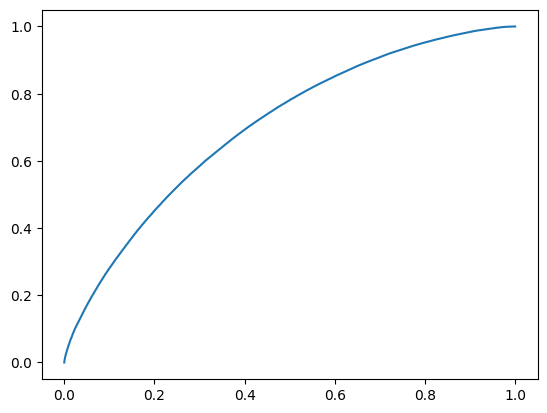

In [10]:
fig, ax = plt.subplots(1)

ax.plot(fpr_val, tpr_val)

print('AUC: {:.3f}'.format(roc_auc_score(val_logits['labels'], val_logits['logits'])))

In [11]:
metrics = {
    'mcc': matthews_corrcoef,
    'accuracy': accuracy_score,
    'f1': f1_score
}

metrics_results = {
    'mcc': [],
    'accuracy': [],
    'f1': []
}

min_logit = val_logits['logits'].min()
max_logit = val_logits['logits'].max()
thresholds = np.linspace(min_logit, max_logit, 200)

for x in thresholds:
    predicted_class = val_logits['logits'] > x
    true_class = val_logits['labels']

    for m in metrics:
        metrics_results[m].append(metrics[m](true_class, predicted_class))

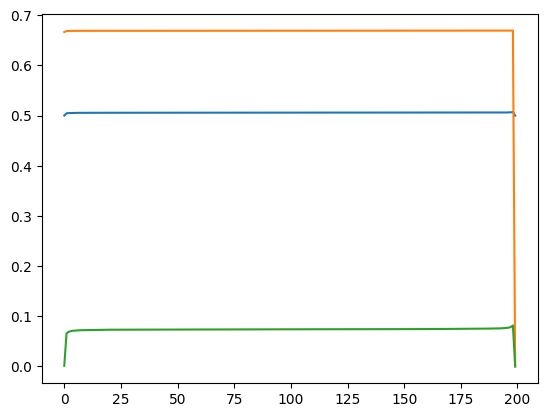

In [12]:
fig, ax = plt.subplots(1)

ax.plot(metrics_results['accuracy'])
ax.plot(metrics_results['f1'])
ax.plot(metrics_results['mcc'])

In [13]:
threshold = thresholds[np.argmax(metrics_results['mcc'])]

In [14]:
predicted = val_logits['logits'] > threshold

print('Accuracy:    {:.3f}'.format(accuracy_score(predicted, val_logits['labels'])))
print('F1:          {:.3f}'.format(f1_score(predicted, val_logits['labels'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(predicted, val_logits['labels'])))

Accuracy:    0.507
F1:          0.670
MCC:         0.082


### Test analysis

In [15]:
test_res = pd.read_csv('{}/{}'.format(LONG_TRAINING_DIRECTORY, 'test_results_classification.csv'), index_col=0)

In [16]:
print('Accuracy:    {:.3f}'.format(accuracy_score(test_res['prediction'], test_res['label'])))
print('F1:          {:.3f}'.format(f1_score(test_res['prediction'], test_res['label'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(test_res['prediction'], test_res['label'])))

Accuracy:    0.997
F1:          0.997
MCC:         0.995


In [66]:
test_logits = pd.read_csv('{}/{}'.format(LONG_TRAINING_DIRECTORY, 'logits_test.csv'), index_col=0)

In [67]:
fpr_test, tpr_test, _ = roc_curve(test_logits['labels'], test_logits['logits'])

AUC: 0.717


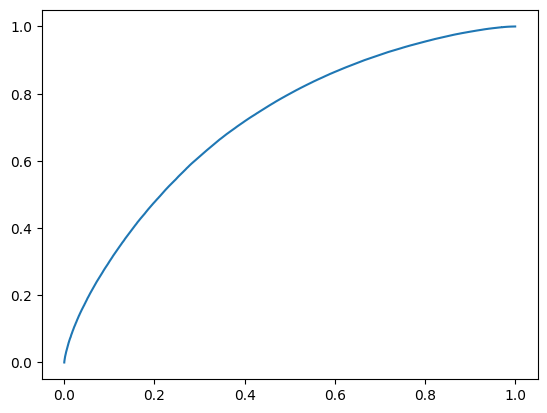

In [68]:
fig, ax = plt.subplots(1)

ax.plot(fpr_test, tpr_test)

print('AUC: {:.3f}'.format(roc_auc_score(test_logits['labels'], test_logits['logits'])))

In [69]:
predicted = test_logits['logits'] > threshold

print('Accuracy:    {:.3f}'.format(accuracy_score(predicted, test_logits['labels'])))
print('F1:          {:.3f}'.format(f1_score(predicted, test_logits['labels'])))
print('MCC:         {:.3f}'.format(matthews_corrcoef(predicted, test_logits['labels'])))

Accuracy:    0.507
F1:          0.669
MCC:         0.078
